# Perform the analyses of retinotopy data

Analyse the data from the Retinotopy experiment. This notebook recreates the figures from the associated manuscript.

**Load in the necessary modules**

In [1]:
import nibabel as nib
import numpy as np
from scipy import stats
import scipy
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.io import loadmat
import sys
import os
from nilearn import plotting
import scipy.spatial.distance as sp_distance
from scipy import stats, ndimage
from nilearn import datasets
import nilearn
from nilearn.input_data import NiftiMasker
import pandas as pd
import glob
from scipy.ndimage.morphology import binary_dilation
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from statsmodels.stats.anova import AnovaRM

%matplotlib inline

np.random.seed(0)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  r

**Set the directories**

In [2]:
# Set the directories
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir)
data_dir = base_dir + 'data/Retinotopy/'
plot_dir = data_dir + 'plots/'
phases = 1 # What is the minimum number of phases per participant?

In [3]:
def find_min_max_coords(stat_map):
    # Find the min and max MNI coordinates of the provided volume
    
    # Load the data and find the coords for the min and max
    nii = nib.load(stat_map)
    vol = nii.get_data()
    min_coords = np.where(vol == np.min(vol))
    max_coords = np.where(vol == np.max(vol))

    min_coords_mni = nilearn.image.coord_transform(min_coords[0], min_coords[1], min_coords[2], nii.affine)
    max_coords_mni = nilearn.image.coord_transform(max_coords[0], max_coords[1], max_coords[2], nii.affine)
    
    return min_coords_mni, max_coords_mni
    

def extract_av_area(ppt, fs_name='iBEAT', suffix_name='.manual', use_uncertain_ROIs=False):
    # Pull out the average area for this participant for each ROI
    # If use_uncertain_ROIs==True then ROIs with +10 what they should be will be considered (i.e., if the region is normally labelled with a 2 then the 12s will also count).
    
    # Set up the names for this participant
    suma_dir = glob.glob('%s/iBEAT/%s/SUMA/' % (data_dir, ppt))[0]
    
    # Set up the var
    av_area = {'lh': [], 'rh': []}

    # Cycle through hemispheres and ROIs
    for hemisphere in ['lh', 'rh']:

        for roi_counter, roi in enumerate(rois):

            # Get the file names
            wm_file = '%s/ROI_%s%s/%s_area_%d_wm.txt' % (suma_dir, hemisphere, suffix_name, hemisphere, roi_counter + 1)
            pial_file = '%s/ROI_%s%s/%s_area_%d_pial.txt' % (suma_dir, hemisphere, suffix_name, hemisphere, roi_counter + 1)
            
            if os.path.exists(wm_file) > 0:

                wm_area = np.sum(np.loadtxt(wm_file))
                pial_area = np.sum(np.loadtxt(pial_file))

                # Average and store the two estimates
                av_area[hemisphere] += [(wm_area + pial_area) / 2]
                
                # If you have said to use uncertain ROIs then specify that here and load them in
            elif use_uncertain_ROIs == True:
                
                wm_file = '%s/ROI_%s%s/%s_area_%d_wm.txt' % (suma_dir, hemisphere, suffix_name, hemisphere, roi_counter + 11)
                pial_file = '%s/ROI_%s%s/%s_area_%d_pial.txt' % (suma_dir, hemisphere, suffix_name, hemisphere, roi_counter + 11)
                
                # Get the data if appropriate
                if os.path.exists(wm_file) > 0:

                    wm_area = np.sum(np.loadtxt(wm_file))
                    pial_area = np.sum(np.loadtxt(pial_file))

                    # Average and store the two estimates
                    av_area[hemisphere] += [(wm_area + pial_area) / 2]
                else:
                    print('Missing %s %s' % (hemisphere, roi))
                    av_area[hemisphere] += [np.nan]
            else:
                print('Missing %s %s' % (hemisphere, roi))
                av_area[hemisphere] += [np.nan]
            
    # Return the result        
    return av_area


def plot_ROIs(av_area, normalize_to_V1 = 1):
    # Plot the area of each ROI
    # normalize_to_V1 means whether you are going to use V1 for normalizing your values to (i.e., divide the size of the region by the size of V1)

    temp_rois = np.copy(rois)
    plt.figure()
    for hemi_counter, hemisphere in enumerate(['lh', 'rh']):

        # Do you want to normalize the values to the area of V1?
        if normalize_to_V1 == 1:
            # Normalize to ventral and dorsal V1 separately
            hemi_area = np.hstack([np.asarray(av_area[hemisphere][1:4]) / av_area[hemisphere][0], np.asarray(av_area[hemisphere][5:]) / av_area[hemisphere][4]])
            temp_rois = np.asarray(rois)[[1, 2, 3, 5, 6, 7]]
        else:
            hemi_area = np.asarray(av_area[hemisphere])

        # Plot this hemifield
        bar_width = 0.3
        bar_x_coords = np.arange(len(hemi_area)) - (hemi_counter * bar_width) + (bar_width / 2) 
        plt.bar(bar_x_coords, hemi_area, width=bar_width)

        plt.xticks(np.arange(len(hemi_area)), temp_rois)
        
        if normalize_to_V1 == 1:
            plt.ylabel('Proportion area of V1')
        else:
            plt.ylabel('Area')
    plt.legend(['lh', 'rh'])
    
    
def extract_av_area_between(ppt):
    # Extract the average area between the dorsal and ventral streams. Looks for files with the name: between_manual
    suffix_name = '.between_manual'
    
    # Set up the names for this participant
    suma_dir = glob.glob(data_dir + 'iBEAT/%s/SUMA/' % (ppt))[0]

    # Set up the var
    av_area = {'lh': [], 'rh': []}

    # Cycle through hemispheres and ROIs
    for hemisphere in ['lh', 'rh']:

        for roi_counter, roi in enumerate(['V1', 'V2', 'V3']):

            # Get the file names
            wm_file = '%s/ROI_%s%s/%s_area_%d_wm.txt' % (suma_dir, hemisphere, suffix_name, hemisphere, roi_counter + 31)
            pial_file = '%s/ROI_%s%s/%s_area_%d_pial.txt' % (suma_dir, hemisphere, suffix_name, hemisphere, roi_counter + 31)
            
            # If the files exist then load this data
            if os.path.exists(wm_file) > 0:

                wm_area = np.sum(np.loadtxt(wm_file))
                pial_area = np.sum(np.loadtxt(pial_file))

                # Average and store the two estimates
                av_area[hemisphere] += [(wm_area + pial_area) / 2]
                
            else:
                print('Missing %s %s' % (hemisphere, roi))
                av_area[hemisphere] += [np.nan]
            
    # Return the result        
    return av_area


def load_1D(input_file, expected_length=198812):
    # Read in 1D or 1D.dset files into a numpy array. 
    # Will assume the data is in std.141 format so that everything is length 198812. The first column is assumed to be indexes. If they are not then the vector also has to be length 198812. 
    # Will ignore any # at the start and end
    # Can deal with sparse 1D files as well as dense ones (i.e., where the first column lists indexes) 
    # An ROI file can be converted into the appropriate format using 
    # `ROI2dataset -prefix $output -keep_separate -of 1D -input $input`
    
    # Load in the file ignoring comments
    vec = np.loadtxt(input_file, comments='#')
    
    if len(vec) == 0:
        print('Error, %s empty' % input_file)
        return -1
     
    # If the expected_length is set to -1 then you just return this vec anyway
    if expected_length == -1:

        return vec  
    
    # Check whether the first column already has all the indexes
    elif expected_length == len(np.unique(vec[:, 0])):

        # Just clip off this first column and go
        return vec[:, 1:]

    # If this isn't just a list of indexes but is the correct length, then also just go
    elif expected_length == vec.shape[0]:

        return vec

    # If neither of the above are true, assume this is a dense 1D file where the first column are indexes
    else:

        # What is the size of the output vector
        output_vec = np.zeros((expected_length, vec.shape[1] - 1))

        # input the data
        output_vec[vec[:,0].astype('int16'), :] = vec[:, 1:]

        return output_vec
    
# How to convert the labels I used with the Wang atlas. 
# The keys are the names of the ROIs I defined, as well as the number used for the label
# The codes are the ROI numbers for the Wang atlas. Relevant for both which ROI file to load and also for the max probability files
#manual2Wang = {'vV1-1': [1], 'vV2-2': [3], 'vV3-3': [5], 'vV4-4': [7], 'dV1-5': [2], 'dV2-6': [4], 'dV3-7': [6], 'dV3AB-8': [16, 17]}
Wang2manual = {'1': 1, '3': 2, '5': 3, '7': 4, '2': 5, '4': 6, '6': 7, '16': 8, '17': 8}

def convert_std_vec(std_vec, Wang2manual):
    # Change the numbers of the standard atlas to match the numbers I used manually, using the Wang2manual dictionary
    
    output = np.zeros(std_vec.shape)

    # For each value of the Wang atlas that maps on to the manual ROIs find all of the corresponding elements
    for key in Wang2manual:

        output[std_vec == int(key)] = Wang2manual[key]

    return output
    
    
def compute_DICE_1D(vec_1, vec_2, relevant_idxs = None, use_uncertain_ROIs=False):
    # Compute the DICE similarity of two input vectors using both as denominators.
    # If one or both of the vectors has more than one column, this will check if any match. 
    # If `relevant_idxs` is specified, it will only compare DICE based on the supplied integer(s). Can be used if a participant only has a subset of ROIs
    
    # If you want to use uncertain ROIs then just subtract 10 from their value. If you don't want to then make these zero
    if use_uncertain_ROIs == True:
        vec_1[vec_1 > 10] = vec_1[vec_1 > 10] - 10
        vec_2[vec_2 > 10] = vec_2[vec_2 > 10] - 10
    else:
        vec_1[vec_1 > 10] = 0
        vec_2[vec_2 > 10] = 0
    
    # Find the unique values of the vec and then exclude those that are not specified in relevant idxs
    if relevant_idxs is not None:

        # Which values don't overlap? Set those to zero in the data
        non_overlap_vals = list(set(np.unique(vec_1))^set(relevant_idxs))
        for val in non_overlap_vals:
            vec_1[vec_1==val] = 0

        non_overlap_vals = list(set(np.unique(vec_2))^set(relevant_idxs))
        for val in non_overlap_vals:
            vec_2[vec_2==val] = 0

    vec_1_mask = np.sum(vec_1, 1) > 0 
    vec_2_mask = np.sum(vec_2, 1) > 0 
    union_mask = (vec_1_mask + vec_2_mask) > 0 # Which voxels are in either (the denominator)

    matches = 0
    for idx in np.where(union_mask==1)[0]:

        # Pull out the values for this index that are non zeros
        val_1 = vec_1[idx, vec_1[idx, :] > 0]
        val_2 = vec_2[idx, vec_2[idx, :] > 0]

        # Are there any values that intersect?
        matches += len(np.intersect1d(val_1, val_2)) > 0

    # Compute the DICE score   
    DICE = matches / np.sum(union_mask)    

    return DICE
    
    
def load_roi(input_file):
    # Load the roi file (this preserves the order posterior to anterior whereas other file types don't).
    # Each list entry includes values of all intervening nodes along a line
        
    # Load the file
    fid = open(input_file, 'r')

    # Increment through each line
    line = fid.readline()
    trace_counter = 0
    while len(line) > 0:
        # Is this line the start of a new trace, if so then increment the counter
        if line == '# <Node_ROI\n':
            trace_counter += 1

            # If this is the first node then preset everything, otherwise append to the growing list
            if trace_counter == 1:
                trace_nodes_all = []
                trace_nodes = []
            else:
                trace_nodes_all += [trace_nodes]
                trace_nodes = []

        # Split the line into words
        words = line.split()

        # If this is a line with content then continue
        if (len(words) > 1) and (words[0] == '1'):

            # Some nodes are repeated and so this avoids that. Don't use unique because that reorders them
            if len(words) > 4:
                nodes = [int(i) for i in words[4:]] 
            else:
                nodes = [int(words[3])]

            trace_nodes += nodes

        # Read a new line
        line = fid.readline()
    
    fid.close()
    
    # Get the last set fir use
    trace_nodes_all += [trace_nodes]
    
    return trace_nodes_all

def compute_line_oscillation_area(ppt, hemi, prefix, meridian_file, sf_file, interpolate_data=True, use_ortho=False):
    # Pull out the node from the lines specified and store. Same as below except it fits to the ROIs in a region (and interpolates)
    
    # Load in the vector files
    meridian_vec = load_1D(meridian_file, expected_length=-1)
    sf_vec = load_1D(sf_file, expected_length=-1)
    
    max_len_quarter = max_len / 4
    
    # Get the file names
    padded_1D_file = '%s/iBEAT/%s/SUMA/%s.manual_padded.1D.dset' % (data_dir, ppt, hemi)

    # Print the nodes that overlap between two files or arrays
    ROIs_array = load_1D(padded_1D_file, expected_length=-1)
    
    # Specify the file with lines
    if use_ortho == True:
        lines_file = '%s/iBEAT/%s/SUMA/%s%s.ortho_lines.niml.roi' % (data_dir, ppt, prefix, hemi)
    else:
        lines_file = '%s/iBEAT/%s/SUMA/%s%s.lines.niml.roi' % (data_dir, ppt, prefix, hemi)

    # Load the roi file (different format)
    line_vecs = load_roi(lines_file)

    # Cycle through the line vectors (should be five per file)
    meridian_vals_interp = np.ones((max_len, len(line_vecs))) * np.nan
    sf_vals_interp = np.ones((max_len, len(line_vecs))) * np.nan
    for line_counter, line_vec in enumerate(line_vecs):

        for ROI_counter in [1, 2, 3, 4]:
        
            # Grab the nodes for this array
            if prefix == 'v':
                nodes, _ = np.where(ROIs_array == (ROI_counter))
            else:
                nodes, _ = np.where(ROIs_array == (ROI_counter + 4))
            
            from_idx = int((ROI_counter - 1) * max_len_quarter)
            to_idx = int(ROI_counter * max_len_quarter)
            
            # If there are nodes then fill in, otherwise skip
            if len(nodes) > 0:

                # Get the usable nodes for this line_vec
                usable_nodes = []
                for node in line_vec:
                    if node in nodes:
                        usable_nodes += [node]
                
                # For some lines there are none (but other lines some) and so skip those
                if len(usable_nodes) > 1:

                    # Line vec contains the idxs to be considered, going posterior to anterior
                    meridian_vals = meridian_vec[usable_nodes]
                    sf_vals = sf_vec[usable_nodes]

                    # Interpolate these values so that there are equivalent numbers regardless of the length of line_vec
                    finterp_meridian = scipy.interpolate.interp1d(np.linspace(0, max_len_quarter - 1, len(usable_nodes)), meridian_vals)
                    finterp_sf = scipy.interpolate.interp1d(np.linspace(0, max_len_quarter - 1, len(usable_nodes)), sf_vals)

                    # Store interpolated values
                    meridian_vals_interp[from_idx:to_idx, line_counter] = finterp_meridian(np.arange(max_len_quarter))
                    sf_vals_interp[from_idx:to_idx, line_counter] = finterp_sf(np.arange(max_len_quarter))

    return meridian_vals_interp, sf_vals_interp


def compute_line_oscillation(ppt, hemi, prefix, meridian_file, sf_file, interpolate_data=True):
    # Pull out the node from the lines specified and store
    
    # Load in the vector files
    meridian_vec = load_1D(meridian_file, expected_length=-1)
    sf_vec = load_1D(sf_file, expected_length=-1)

    # How many ROIs in the dorsal and ventral stream
    av_area = extract_av_area(ppt, use_uncertain_ROIs=True) # Have to use uncertain ROIs because that is what was used for drawing

    if prefix is 'v':
        num_ROIs = 4 - np.sum(np.isnan(av_area[hemi][0:4])) 
    else:
        num_ROIs = 4 - np.sum(np.isnan(av_area[hemi][4:]))

    # What proportion of ROI length should be used
    max_len_trimmed = int(max_len * (num_ROIs / 4))
    
    # Specify the file with lines
    lines_file = '%s/iBEAT/%s/SUMA/%s%s.lines.niml.roi' % (data_dir, ppt, prefix, hemi)
    
    # Load the roi file (different format)
    line_vecs = load_roi(lines_file)

    # Cycle through the line vectors (should be five per file)
    meridian_vals_interp = np.ones((max_len, len(line_vecs))) * np.nan
    sf_vals_interp = np.ones((max_len, len(line_vecs))) * np.nan
    for line_counter, line_vec in enumerate(line_vecs):

        # Line vec contains the idxs to be considered, going posterior to anterior
        meridian_vals = meridian_vec[line_vec]
        sf_vals = sf_vec[line_vec]

        if interpolate_data:
            # Interpolate these values so that there are equivalent numbers regardless of the length of line_vec
            finterp_meridian = scipy.interpolate.interp1d(np.linspace(0, max_len_trimmed - 1, len(line_vec)), meridian_vals)
            finterp_sf = scipy.interpolate.interp1d(np.linspace(0, max_len_trimmed - 1, len(line_vec)), sf_vals)

            # Store interpolated values
            meridian_vals_interp[:max_len_trimmed, line_counter] = finterp_meridian(np.arange(max_len_trimmed))
            sf_vals_interp[:max_len_trimmed, line_counter] = finterp_sf(np.arange(max_len_trimmed))
        else:
            meridian_vals_interp[:len(meridian_vals), line_counter] = meridian_vals
            sf_vals_interp[:len(sf_vals), line_counter] = sf_vals

    return meridian_vals_interp, sf_vals_interp


def partial_corr(x,y,covar):
    # Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling for the remaining variables in C.
    
    x = np.asarray(x)
    y = np.asarray(y)
    covar = np.asarray(covar)
    slope, intercept, r_value, p_value, std_err = stats.linregress(covar,x)
    resids_xcovar=x-(covar*slope+intercept)
    slope, intercept, r_value, p_value, std_err = stats.linregress(covar,y)
    resids_ycovar=y-(covar*slope+intercept)
    slope, intercept, r_value, p_value, std_err = stats.linregress(resids_ycovar,resids_xcovar)
    return r_value,p_value


def randomise_corr(x_vals, y_vals, resample_num=10000, cov_vals=None):        
    # Perform bivariate bootstrap resampling: take N samples with replacement from x and y and compute the correlation. Do this X times and report the p value of the number of samples in the opposite direction from the true effect, doubled to make two tail
    
    # Check that the metrics aren't lists
    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals)    
    
    # Resample the participants
    resample_corr = []
    for i in range(resample_num):

        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(x_vals), (1, len(x_vals)))
        
        if cov_vals is None:
            resample_corr += [np.corrcoef(x_vals[sub_idx], y_vals[sub_idx])[0, 1]]
        else:
            partial_corr_val, _ = partial_corr(x_vals[sub_idx], y_vals[sub_idx], cov_vals[sub_idx])
            resample_corr += [partial_corr_val]

    # Calculate the 2 way p value
    p_val = (1 - (np.sum(np.asarray(resample_corr) > 0) / (resample_num + 1))) * 2
    
    # If greater than 1 then subtract from 2
    if p_val > 1:
        p_val = 2 - p_val
    
    # return the corr p value
    return p_val


def randomise_diff(diff_data, resample_num=10000):        
    # Bootstrap resampling. Take N samples with replacement and compute a mean of the sample. Do this X times and report the p value of the number of samples in the opposite direction from the true effect, doubled to make two tail
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(diff_data), (1, len(diff_data)))

        resample_diff += [np.mean(diff_data[sub_idx])]
    
    # What direction was the effect
    sign_count = np.sum((diff_data) > 0)
    
    # Calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0) + 1) / (resample_num + 1))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    # return the difference in ROI and 
    return p_val, sign_count, CIs


def randomise_diff_2sample(data_1, data_2, resample_num=10000):        
    # Bootstrap resampling for independent samples. Take N samples with replacement from each group separately, average within group and then subtract. Do this X times and report the p value of the number of samples in the opposite direction from the true effect, doubled to make two tail
    
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx_1 = np.random.randint(0, len(data_1), (1, len(data_1)))
        
        sub_idx_2 = np.random.randint(0, len(data_2), (1, len(data_2)))

        resample_diff += [np.mean(data_1[sub_idx_1]) - np.mean(data_2[sub_idx_2])]
    
    # Calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0) + 1) / (resample_num + 1))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    mean_diff = np.mean(data_1) - np.mean(data_2)
    
    # return the difference in ROI and 
    return p_val, mean_diff, CIs


def plot_line_oscillations(plot_cond, prefix, max_len, interpolate_data, interpolate_within_roi, aggregate_lines, use_ortho=False, run_nonparametric=0, ppt_idxs=[-1]):
        # Take in information about the condition and then load the manually traced lines and quantify the values of the specified contrast along those traced lines.
#     plot_cond = 'sf' # What condition are you plotting?
#     max_len = 200 # What is the max list length (used for interpolation) and trimmed if fewer ROIs are found
#     interpolate_data = True # Do you want to interpolate data within line so that they are approximately the same length within participant?
#     interpolate_within_roi = True # Do you want to interpolate so that each ROI within a hemifield are the same length (makes the above irrelevant)
#     aggregate_lines = 1 # How to aggregate across lines. 0 just means average, 1 means z score then average 2 means average then z score
#     use_otho = False # Do you want to use the vertical lines (false) or horizontal lines (true)
#     run_nonparametric = 0 # Do you want to plot the non parametric distribution, either by shuffling (1) or by bootstrapping (2)
#     ppt_idxs = -1 # What participants do you want to use (from the df). If -1 it will use them all


    plt.figure()
    plt.title('%s both hemispheres' % (prefix))
    
    # Get the participants
    ppts = list(df['ID'])
    
    # If a different number is supplied then grab different participants
    if ppt_idxs[0] > -1:
        ppts = np.asarray(ppts)[np.asarray(ppt_idxs)]
        print('Using:', ppts)
    
    data_vals_all = np.zeros((len(ppts), max_len, 2)) * np.nan
    for hemi_counter, hemi in enumerate(['lh', 'rh']):

        # Cycle through ppts    
        for ppt_counter, ppt in enumerate(ppts):

            if use_ortho == True:
                lines_file = '%s/iBEAT/%s/SUMA/%s%s.lines.niml.roi' % (data_dir, ppt, prefix, hemi)
            else:
                lines_file = '%s/iBEAT/%s/SUMA/%s%s.ortho_lines.niml.roi' % (data_dir, ppt, prefix, hemi)

            meridian_file = '%s/iBEAT/%s/SUMA/meridian_zstat3.%s.1D.dset' % (data_dir, ppt, hemi)
            sf_file = '%s/iBEAT/%s/SUMA/sf_zstat3.%s.1D.dset' % (data_dir, ppt, hemi)

            # Only proceed if the file exists
            if os.path.exists(lines_file) > 0:

                # Pull out the meridian and sf values for this data
                if interpolate_within_roi:
                    meridian_vals, sf_vals = compute_line_oscillation_area(ppt, hemi, prefix, meridian_file, sf_file, interpolate_data=interpolate_data, use_ortho=use_ortho)
                else:
                    meridian_vals, sf_vals = compute_line_oscillation(ppt, hemi, prefix, meridian_file, sf_file, interpolate_data=interpolate_data)

                # Plot the values
                if plot_cond == 'sf':
                    data_vals = sf_vals
                else:
                    data_vals = meridian_vals

                # Aggregate across the lines
                if aggregate_lines == 0:
                    data_vals = np.nanmean(data_vals, 1)
                elif aggregate_lines == 1:
                    # First z score then average
                    data_vals = np.nanmean((data_vals - np.nanmean(data_vals, axis=0)) / np.nanstd(data_vals, axis=0), 1)
                elif aggregate_lines == 2:
                    # First average then z score
                    data_vals = stats.zscore(np.nanmean(data_vals, 1), axis=0)

                # Store the data for all ppts
                data_vals_all[ppt_counter, :, hemi_counter] = data_vals

    # collapse the hemisphere
    data_vals_all = np.nanmean(data_vals_all, 2)

    if run_nonparametric > 0:
        resamples = 10000
        if run_nonparametric == 1:
            # Do phase rolling (which conflates within and between subject variance)

            # Compute the bounds of the data
            shuffled_time_course = np.zeros((resamples, data_vals_all.shape[1]))
            for resample_counter in range(resamples):
                shuffled_time_course_resample = np.zeros(data_vals_all.shape)
                for ppt_counter in range(data_vals_all.shape[0]):
                    roll_shift = np.random.randint(1, data_vals_all.shape[1]) # Don't include 0 or 200
                    shuffled_time_course_resample[ppt_counter, :] = np.roll(data_vals_all[ppt_counter, :], roll_shift)

                # Store the reshuffled data
                shuffled_time_course[resample_counter, :] = np.nanmean(shuffled_time_course_resample, 0)

        elif run_nonparametric == 2:
            # Do bootstrap resampling

            # Compute the bounds of the data
            shuffled_time_course = np.zeros((resamples, data_vals_all.shape[1]))
            for resample_counter in range(resamples):
                resampled_ppts = np.random.choice(np.arange(data_vals_all.shape[0]), size=data_vals_all.shape[0])
                shuffled_time_course[resample_counter, :] = np.nanmean(data_vals_all[resampled_ppts, :], 0)

    # Plot the data
    std_err = np.nanstd(data_vals_all, 0) / np.sqrt(np.sum(np.isnan(data_vals_all) == 0, 0))
    lower_err = np.nanmean(data_vals_all, 0) - std_err
    upper_err = np.nanmean(data_vals_all, 0) + std_err
    if use_ortho == False:
        
        # Decide what error to show
        if run_nonparametric == 0:
            plt.fill_between(np.arange(max_len), lower_err, upper_err, color=[0.5, 0.5, 0.5])
        else:
            # For each index, get the 2.5 and 97.5 percentile
            lower_shuffle_bound = []
            upper_shuffle_bound = []

            for node_counter in range(data_vals_all.shape[1]):
                lower_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 2.5)]
                upper_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 97.5)]    

            # Plot the distribution
            plt.fill_between(np.arange(max_len), lower_shuffle_bound, upper_shuffle_bound, color=[0, 0, 0.8], alpha=0.25)

        plt.plot(data_vals_all.T, color=[0.8, 0.8, 0.8], linewidth=0.5)

        plt.plot(np.nanmean(data_vals_all, 0), color='k', linewidth=3)

        ortho_name = ''
    else:

        # Increment through the segments
        for segment_counter in range(4):

            # What indexes to pull from
            from_idx = int(segment_counter * max_len / 4)
            to_idx = int((segment_counter + 1) * max_len / 4)
            
            if run_nonparametric == 0:
                plt.fill_between(np.arange(from_idx, to_idx), lower_err[from_idx:to_idx], upper_err[from_idx:to_idx], color=[0.5, 0.5, 0.5])
            else:
                # For each index, get the 2.5 and 97.5 percentile
                lower_shuffle_bound = []
                upper_shuffle_bound = []

                for node_counter in np.arange(from_idx, to_idx):
                    lower_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 2.5)]
                    upper_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 97.5)]    

                # Plot the distribution
                plt.fill_between(np.arange(from_idx, to_idx), lower_shuffle_bound, upper_shuffle_bound, color=[0, 0, 0.8], alpha=0.25)

            plt.plot(np.arange(from_idx, to_idx), data_vals_all[:, from_idx:to_idx].T, color=[0.8, 0.8, 0.8], linewidth=0.5)

            plt.plot(np.arange(from_idx, to_idx), np.nanmean(data_vals_all, 0)[from_idx:to_idx], color='k', linewidth=3)

        ortho_name = '_ortho'
    
#     # Compute a summary statistic as the range of the data for each region, in some way reflecting the amount of change
#     range_vals = np.zeros((data_vals_all.shape[0], 4, 49))
#     for segment_counter in range(4):

#         # What indexes to pull from
#         from_idx = int(segment_counter * max_len / 4)
#         to_idx = int((segment_counter + 1) * max_len / 4)
        
#         segment_data = data_vals_all[:, from_idx:to_idx]
        
#         for roll_counter in range(range_vals.shape[2]):
            
#             # Roll the data (by 1 since you are doing it to itself)
#             segment_data = np.roll(segment_data, 1, 1)
            
#             # What is the range
#             range_vals[:, segment_counter, roll_counter] = np.nanmean(segment_data[:, 0:5], 1) - np.nanmean(segment_data[:, -5:-1], 1)

    # Specify the name
    if interpolate_within_roi:
        interp_name = 'within_roi'
    else:
        interp_name = ['raw', 'interpolated'][interpolate_data]
    
    # Return the output name
    output_name = '%s/oscillation_%s_%s_%s_aggregate-%d%s.svg' % (plot_dir, prefix, plot_cond, interp_name, aggregate_lines, ortho_name)
    return output_name, data_vals_all


def split_quartile(data_vals, region_counter):
    # Take the output of the `plot_line_oscillations` function to compute stats on whether there is a difference within a region, using the 1st and 4th quartile
    
    #  Get the quartiles of data and average them
    start_idx = int(region_counter * max_len / 4)
    first_quartile = np.mean(data_vals[:, start_idx:start_idx + window], 1)
    
    end_idx = int((region_counter + 1) * max_len / 4)
    end_quartile = np.mean(data_vals[:, end_idx - window:end_idx], 1)
    
    diff_quartile = first_quartile - end_quartile
    diff_quartile = diff_quartile[np.isnan(diff_quartile) == 0]
    
    # Calculate the difference
    pval, _, CI = randomise_diff(diff_quartile)
    
    # Get correlation with age
    rval = np.corrcoef(diff_quartile, np.asarray(list(df['Age']))[np.isnan(first_quartile) == 0])[0, 1]
    pval_corr = randomise_corr(diff_quartile, np.asarray(list(df['Age']))[np.isnan(first_quartile) == 0])
    
    print('Start=%0.2f, end=%0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (np.nanmean(first_quartile), np.nanmean(end_quartile), CI[0], CI[1], pval))
    print('Correlation with age r=%0.2f, p=%0.3f' % (rval, pval_corr))

    

## Sumarise the participant data
Create a table summarizing the data for each participant

In [4]:
# Load in the data
df = pd.read_csv(data_dir + '/participant_information.csv', index_col=0)

df

,ID,Age,Sex,Vertical phases,Horizontal phases,Low phases,High phases,Blocks,Runs,prop_TR_included,prop_eye_included,Intraframe reliability,Coder number
0,s8687_1_5,17.1,F,4,4,4,2,8,1,0.983957,0.893102,0.862168,2
1,s8687_1_8,23.1,F,4,5,5,3,10,1,0.982759,0.906358,0.764113,2
2,s6687_1_4,15.4,F,5,6,6,4,12,1,1.000000,0.914640,0.842136,2
3,s6687_1_5,18.1,F,5,4,6,5,11,1,1.000000,0.885211,0.842195,2
4,s6687_1_6,20.1,F,4,3,4,4,8,2,0.972973,0.915071,0.828694,2
5,s4607_1_4,13.0,F,5,5,4,6,12,3,0.927536,0.870712,0.723145,2
6,s4607_1_7,18.5,F,2,3,3,4,7,1,1.000000,0.920764,0.706016,3
7,s1607_1_4,14.4,M,3,2,3,4,8,1,0.936170,0.890148,0.790527,3
8,s7017_1_3,7.2,F,6,6,6,6,12,1,1.000000,0.947026,0.781907,2
9,s8037_1_2,12.2,F,2,2,1,3,5,3,0.904348,0.890300,0.747640,2


**Print the participant information**  
Use formating that latex can recognize

In [5]:
# What are the keys you want from the table and what are their formats
key_formats = {'Age': '%0.1f',
               'Sex': '%s',  
               'Vertical phases': '%d', 
               'Horizontal phases': '%d',
               'Low phases': '%d',
               'High phases': '%d',
               'prop_TR_included': '%0.2f',
               'prop_eye_included': '%0.2f',
               'Intraframe reliability': '%0.2f',
              }

# Resort the idxs by age
resorted_idxs = df.index.values[np.argsort(df['Age'])]

for ppt_idx in resorted_idxs:
    
    # What is the ID for this participant 
    print_str = df['ID'][ppt_idx]
    for key in key_formats.keys():
        
        key_val = df[key][ppt_idx]
        
        # Append to the string differently if it is a string or num
        print_str += (' & ' + key_formats[key]) % key_val
    
    print_str += '\\\\'
    
    print(print_str)

# Print an extra row of the means
print('\hline')
print_str = 'Av.'
for key in key_formats.keys():
    
    if key == 'Sex':
        key_val = '.'
        key_format = '%s'
    else:
        key_val = np.mean(df[key])
        key_format = '%0.2f'
    
    # Append to the string differently if it is a string or num
    print_str += (' & ' + key_format) % key_val

print_str += '\\\\'
print(print_str)
    

s2077_1_1 & 4.8 & M & 5 & 4 & 1 & 3 & 1.00 & 0.92 & 0.76\\
s2097_1_1 & 5.2 & M & 4 & 4 & 4 & 4 & 1.00 & 0.95 & 0.83\\
s8047_1_1 & 5.4 & F & 2 & 3 & 1 & 2 & 0.97 & 0.93 & 0.80\\
s4047_1_1 & 5.5 & F & 3 & 3 & 4 & 4 & 1.00 & 0.95 & 0.82\\
s2097_1_2 & 7.0 & M & 1 & 1 & 4 & 2 & 0.99 & 0.94 & 0.81\\
s7017_1_3 & 7.2 & F & 6 & 6 & 6 & 6 & 1.00 & 0.95 & 0.78\\
s7047_1_1 & 9.6 & F & 1 & 1 & 1 & 1 & 1.00 & 0.91 & 0.77\\
s7067_1_4 & 10.6 & F & 3 & 3 & 2 & 3 & 1.00 & 0.89 & 0.78\\
s8037_1_2 & 12.2 & F & 2 & 2 & 1 & 3 & 0.90 & 0.89 & 0.75\\
s4607_1_4 & 13.0 & F & 5 & 5 & 4 & 6 & 0.93 & 0.87 & 0.72\\
s1607_1_4 & 14.4 & M & 3 & 2 & 3 & 4 & 0.94 & 0.89 & 0.79\\
s6687_1_4 & 15.4 & F & 5 & 6 & 6 & 4 & 1.00 & 0.91 & 0.84\\
s8687_1_5 & 17.1 & F & 4 & 4 & 4 & 2 & 0.98 & 0.89 & 0.86\\
s6687_1_5 & 18.1 & F & 5 & 4 & 6 & 5 & 1.00 & 0.89 & 0.84\\
s4607_1_7 & 18.5 & F & 2 & 3 & 3 & 4 & 1.00 & 0.92 & 0.71\\
s6687_1_6 & 20.1 & F & 4 & 3 & 4 & 4 & 0.97 & 0.92 & 0.83\\
s8687_1_8 & 23.1 & F & 4 & 5 & 5 & 3 & 0.98 & 0

<input>:32: DeprecationWarning: invalid escape sequence \h
<ipython-input-5-f4e1af510b48>:32: DeprecationWarning: invalid escape sequence \h
  print('\hline')


**Print various descriptives about the data**

In [6]:
session_IDs = list(df['ID'])
ppt_IDs = []
for session_ID in session_IDs:
    ppt_IDs += [session_ID[:-2]]

ppt_ID_counts = [[x, ppt_IDs.count(x)] for x in set(ppt_IDs)]

ppt_ID_count = []
age_diffs = []
for repeat_session in ppt_ID_counts:
    
    # Add total
    ppt_ID_count += [repeat_session[1]]
    
    # If this is a repeated session
    if repeat_session[1] > 1:
    
        session_idxs = np.where(np.asarray(ppt_IDs) == repeat_session[0])[0]
        #print(repeat_session[0])
        #print(list(np.diff(np.asarray(df['Age'])[session_idxs])))
        age_diffs += list(np.diff(np.asarray(df['Age'])[session_idxs]))
    
ppt_ID_count = np.asarray(ppt_ID_count) # Convert the ppt ID


print('Sex: F=%d M=%d' % (np.sum(df['Sex'] == 'F'), np.sum(df['Sex'] == 'M')))
print('Ages %0.1f to %0.1f (M=%0.1f [SD=%0.1f])' % (np.min(df['Age']), np.max(df['Age']), np.mean(df['Age']), np.std(df['Age'])))
print('Repeat sessions: two repeats = %d, three repeats = %d' % (np.sum(ppt_ID_count == 2), np.sum(ppt_ID_count == 3)))
print('Repeat lag %0.1f to %0.1f (M=%0.1f [SD=%0.1f])' % (np.min(age_diffs), np.max(age_diffs), np.mean(age_diffs), np.std(age_diffs)))

key = 'Blocks'
print('Average blocks per participant: %0.2f (SD=%0.2f), min=%d, max=%d' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))

key = 'Coder number'
print('Average Coders per participant: %0.2f (SD=%0.2f), min=%d, max=%d' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))

key = 'Intraframe reliability'
print('Average %s per participant: %0.3f (SD=%0.3f), min=%0.3f, max=%0.3f' % (key, np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))

key = 'prop_TR_included'
print('Average TRs included per participant: %0.3f (SD=%0.3f), min=%0.3f, max=%0.3f' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))

key = 'prop_eye_included'
print('Average eye data included per participant: %0.3f (SD=%0.3f), min=%0.3f, max=%0.3f' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))
print('Correlation between proportion included eye data and age: %0.3f' % (np.corrcoef(df[key], df['Age'])[0, 1]))


for key in ['High phases', 'Low phases', 'Horizontal phases', 'Vertical phases']:
    print('Average number of %s: %0.3f (SD=%0.3f), min=%0.3f, max=%0.3f' % (key, np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))


Sex: F=13 M=4
Ages 4.8 to 23.1 (M=12.2 [SD=5.7])
Repeat sessions: two repeats = 3, three repeats = 1
Repeat lag 1.8 to 6.0 (M=3.6 [SD=1.8])
Average blocks per participant: 7.94 (SD=2.73), min=2, max=12
Average Coders per participant: 2.12 (SD=0.32), min=2, max=3
Average Intraframe reliability per participant: 0.792 (SD=0.042), min=0.706, max=0.862
Average TRs included per participant: 0.981 (SD=0.029), min=0.904, max=1.000
Average eye data included per participant: 0.913 (SD=0.024), min=0.871, max=0.951
Correlation between proportion included eye data and age: -0.546
Average number of High phases: 3.529 (SD=1.334), min=1.000, max=6.000
Average number of Low phases: 3.471 (SD=1.719), min=1.000, max=6.000
Average number of Horizontal phases: 3.471 (SD=1.460), min=1.000, max=6.000
Average number of Vertical phases: 3.471 (SD=1.460), min=1.000, max=6.000


**Plot the age of the participants**

(array([4., 2., 1., 1., 2., 2., 1., 2., 1., 1.]),
 array([ 4.8 ,  6.63,  8.46, 10.29, 12.12, 13.95, 15.78, 17.61, 19.44,
        21.27, 23.1 ]),
 <a list of 10 Patch objects>)

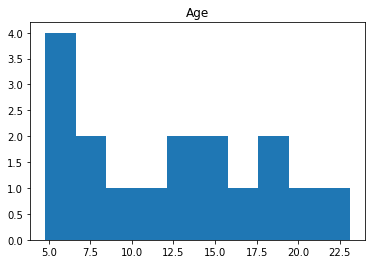

In [7]:
plt.figure()
plt.title('Age')
plt.hist(df['Age'])

**Plot the distribution of eye tracking data**

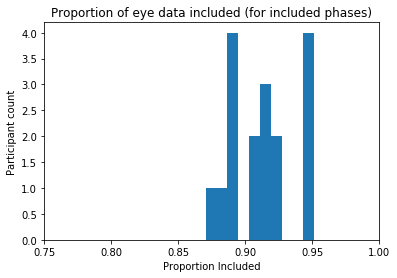

In [8]:
plt.figure()
plt.title('Proportion of eye data included (for included phases)')
plt.hist(df['prop_eye_included'])
plt.xlabel('Proportion Included')
plt.ylabel('Participant count')
plt.xlim([0.75, 1])
plt.savefig(plot_dir + '/proportion_eye_data.svg')


**Quantify the proportion of looking to each dimension for each of the meridian stimuli**  
The aim of this analysis is to test if there is a bias in looking behavior between block types. This quantifies looking behavior in three ways: (1) proportion of usable looking time, (2) proportion of time spent looking at the extreme of the stimulus (e.g., for horizontal it is left/right \[since up/down is not allowed\] and for high it is left/right/up/down since all directions are allowed), (3) number of times the participant switched their fixated location (within the allowable options).

In [9]:
usable_proportions = {'vertical': [], 'horizontal': [], 'high': [], 'low': []}
extremes_proportions = {'vertical': [], 'horizontal': [], 'high': [], 'low': []}
switches = {'vertical': [], 'horizontal': [], 'high': [], 'low': []}
ages = []

# What are considered the extremes for each condition
extreme_keys = {'vertical': [7, 8], 'horizontal': [1, 2], 'high': [1, 2, 7, 8], 'low': [1, 2, 7, 8]}

# Cycle through participants
for ppt_counter, ppt in enumerate(df['ID']):
    
    ages += [list(df['Age'])[ppt_counter]]
    
    behavioral_folder = '%s/Trial_timecourse/' % (data_dir)
    Data_file = behavioral_folder + ppt + '.mat'

    Data_all = loadmat(Data_file, struct_as_record=False)

    # The data is stored as an object in the third list down
    timecourses = Data_all['timecourse_all']
    phase_names = Data_all['phase_name_all']
    eye_exclusions = Data_all['Proportion_EyeTracking_Excluded']
    Include_Blocks = Data_all['Include_Block']
    Include_Events = Data_all['Include_Events']
    
    for key in usable_proportions:

        # Preset
        usable_proportion = []
        extreme_proportion = []
        switch = []
        for block_type_counter in range(timecourses.shape[0]):
            for block_rep_counter in range(timecourses.shape[1]):
                for phase_counter in range(timecourses.shape[2]):
                        
                    timecourse = timecourses[block_type_counter, block_rep_counter, phase_counter] 
                    condition = phase_names[block_type_counter, block_rep_counter, phase_counter]

                    # Is this block excluded
                    eye_exclusion = eye_exclusions[block_type_counter, block_rep_counter, phase_counter]

                    include_block = Include_Blocks[block_type_counter, block_rep_counter, phase_counter]

                    # What are the included events from this block
                    include_events = Include_Events[block_type_counter, block_rep_counter, phase_counter]

                    # Check this is the key you care about both events from this block are included
                    if (key == condition) and (include_block == 1) and (np.mean(include_events) == 1):

                        # How many fixations are there to the extremes
                        extreme_total = 0
                        for extreme_key in extreme_keys[key]:
                              extreme_total += np.sum(timecourse == extreme_key)

                        extreme_proportion += [extreme_total / len(timecourse[0])]                

                        usable_proportion += [1 - eye_exclusion[0]]

                        # Count the number of switches
                        switch += [np.sum(np.diff(timecourse) != 0)]

        usable_proportions[key] += [np.mean(usable_proportion)]
        extremes_proportions[key] += [np.mean(extreme_proportion)]
        switches[key] += [np.mean(switch)]
        
# Report stats for difference
print('Differences between phases')

for comparisons in [['horizontal', 'vertical'], ['high', 'low']]:
    
    print('Correlation of looking to %s with age: r=%0.3f' % ((comparisons[0], np.corrcoef(ages, usable_proportions[comparisons[0]])[0, 1])))
    print('Correlation of looking to %s with age: r=%0.3f' % ((comparisons[1], np.corrcoef(ages, usable_proportions[comparisons[1]])[0, 1])))
    
    pval, sign, CI = randomise_diff(np.asarray(usable_proportions[comparisons[0]]) - np.asarray(usable_proportions[comparisons[1]]))
    print('Proportion of time looking at %s greater than %s: M=%0.3f, %0.3f, CI=[%0.3f, %0.3f], p=%0.3f' % (comparisons[0], comparisons[1], np.mean(usable_proportions[comparisons[0]]), np.mean(usable_proportions[comparisons[1]]), CI[0], CI[1], pval))
    
    pval, sign, CI = randomise_diff(np.asarray(extremes_proportions[comparisons[0]]) - np.asarray(extremes_proportions[comparisons[1]]))
    print('Proportion of time looking at the extremes for %s greater than %s: M=%0.3f, %0.3f, CI=[%0.3f, %0.3f], p=%0.3f' % (comparisons[0], comparisons[1], np.mean(extremes_proportions[comparisons[0]]), np.mean(extremes_proportions[comparisons[1]]), CI[0], CI[1], pval))
    
    pval, sign, CI = randomise_diff(np.asarray(switches[comparisons[0]]) - np.asarray(switches[comparisons[1]]))
    print('Number of switches between looked location for %s greater than %s: M=%0.3f, %0.3f, CI=[%0.3f, %0.3f], p=%0.3f' % (comparisons[0], comparisons[1], np.mean(switches[comparisons[0]]), np.mean(switches[comparisons[1]]), CI[0], CI[1], pval))

    
switches_total = np.asarray(switches['horizontal']) + np.asarray(switches['vertical']) + np.asarray(switches['low']) + np.asarray(switches['high'])

print('Number of switches in looked location correlated with age: r=%0.3f' % (np.corrcoef(df['Age'], switches_total)[0, 1]))    


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Differences between phases
Correlation of looking to horizontal with age: r=-0.594
Correlation of looking to vertical with age: r=-0.496
Proportion of time looking at horizontal greater than vertical: M=0.916, 0.917, CI=[-0.019, 0.016], p=0.877
Proportion of time looking at the extremes for horizontal greater than vertical: M=0.410, 0.298, CI=[0.000, 0.223], p=0.050
Number of switches between looked location for horizontal greater than vertical: M=13.545, 11.982, CI=[-2.129, 5.291], p=0.404
Correlation of looking to high with age: r=-0.347
Correlation of looking to low with age: r=-0.189
Proportion of time looking at high greater than low: M=0.895, 0.909, CI=[-0.040, 0.014], p=0.310
Proportion of time looking at the extremes for high greater than low: M=0.080, 0.046, CI=[0.003, 0.070], p=0.033
Number of switches between looked location for high greater than low: M=6.809, 5.887, CI=[-0.574, 2.490], p=0.247
Number of switches in looked location correlated with age: r=0.093


## Plot the data in volumetric space

**Plot the whole brain task contrast**  
This is an F test where any activity across any condition contributes to the effect. To make the effect selective within participant, each participants volume was z scored, meaning this is asking the relative regions in the brain that are activated by this task

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


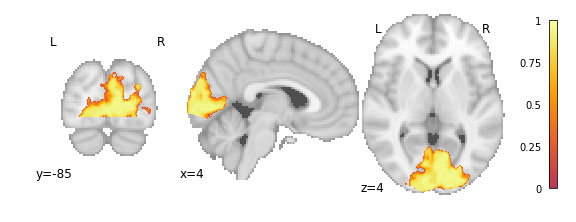

In [10]:
# Plot the whole brain fstat and rescale the color map to go from a 1-p value to a p value
tstat_name = data_dir + 'wholebrain_tstat/fstat1_Z_tfce_corrp_tstat1.nii.gz'

alpha = 0.05

# Load the data and scale it to this range
nii = nib.load(tstat_name)

vol = nii.get_data()

vol = (vol - (1 - alpha)) * (1 / alpha)

vol[vol < 0] = 0

tstat_name = nib.Nifti1Image(vol, nii.affine)

z_range = [0, 0.999]

cmap = 'inferno'
    
# Plot the statistics
nilearn.plotting.plot_stat_map(tstat_name, 
                               threshold=z_range[0], 
                               draw_cross=False, 
                               vmax=z_range[1],
                               symmetric_cbar=False,
                               cmap=cmap,
                              )

plt.savefig('%s/wholebrain_fstat_Z_tfce.svg' % (plot_dir))

**Overlay the contrasts for meridian mapping and spatial frequency on the anatomical images of each participant**

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier 

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes 

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes 

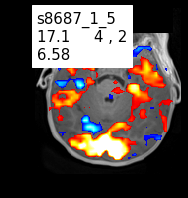

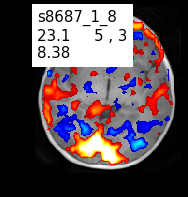

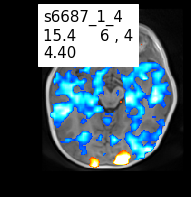

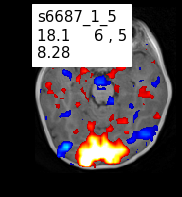

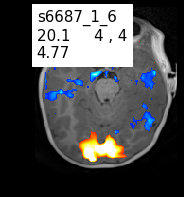

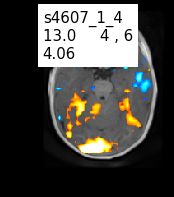

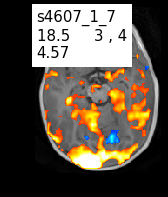

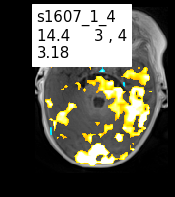

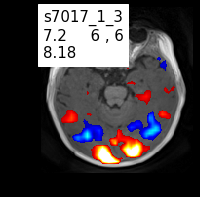

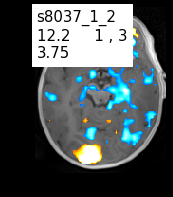

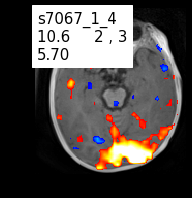

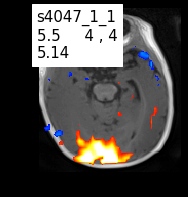

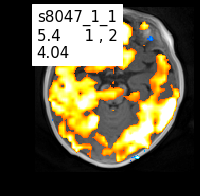

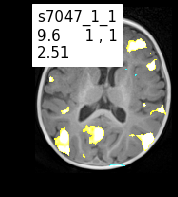

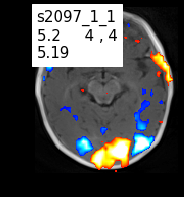

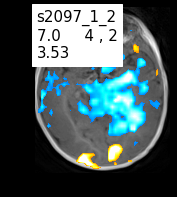

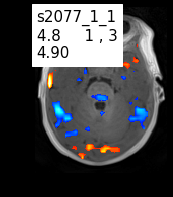

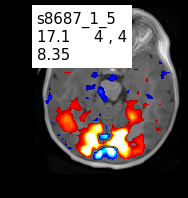

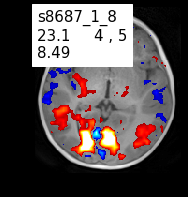

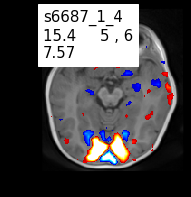

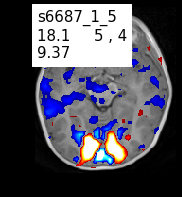

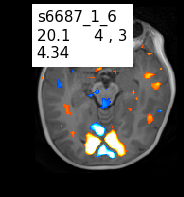

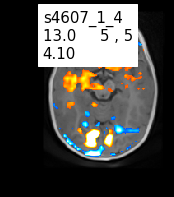

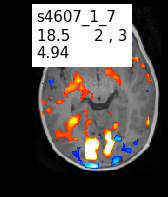

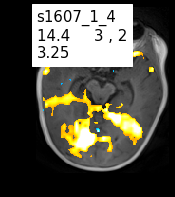

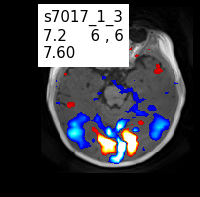

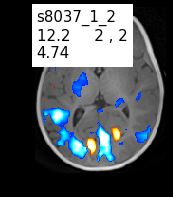

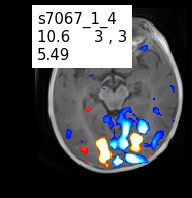

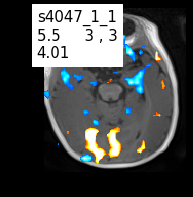

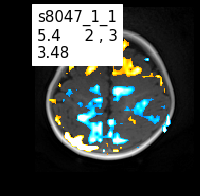

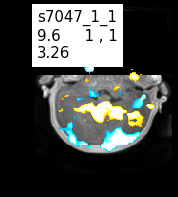

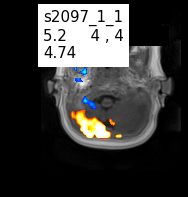

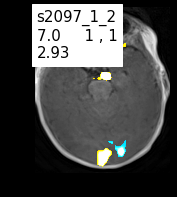

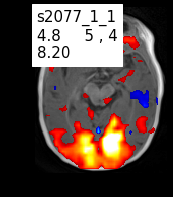

In [11]:
# Plot each participant
threshold = 1.96
black_bg = 1
dim = 0 # What is the dimming rate of the background image
view_style = 'z'
title_save = 0 # Do you want to show the title and save as svg or no title and save as png?

for analysis_type in ['sf', 'meridian']:

    for ppt_counter, ppt in enumerate(df['ID']):
        stat_map = '%s/contrast_maps/%s_%s_zstat3.nii.gz' % (data_dir, ppt, analysis_type)
        anat = '%s/iBEAT/%s/mri/T1.nii.gz' % (data_dir, ppt)
        
        mask_name = '%s/masks/%s_occipital_mask.nii.gz' % (data_dir, ppt)
        mask = nib.load(mask_name).get_data()
        
        # What is the color max
        vol = nib.load('%s/contrast_maps/%s_%s_zstat3.nii.gz' % (data_dir, ppt, analysis_type)).get_data()
        vmax = np.percentile(abs(vol[mask == 1]), 95)
        #print('%s\t%s=%0.2f' % (ppt, analysis_type, vmax))
        
        # Determine what the cut coords are for this syle
        min_coords_mni, max_coords_mni = find_min_max_coords(stat_map)
        
        ppt_age = list(df['Age'])[ppt_counter]
        
        # What are the phases being considered? 
        if analysis_type == 'sf':
            first_phases = list(df['Low phases'])[ppt_counter]
            second_phases = list(df['High phases'])[ppt_counter]
        else:
            first_phases = list(df['Vertical phases'])[ppt_counter]
            second_phases = list(df['Horizontal phases'])[ppt_counter]

        # If viewing from a different angle then ortho then use different cut coords
        if view_style == 'z':
            max_coords_mni = max_coords_mni[2]
            min_coords_mni = min_coords_mni[2]

        # Plot the data
        nilearn.plotting.plot_stat_map(stat_map_img=stat_map, 
                                       bg_img=anat,
                                       display_mode=view_style, 
                                       cut_coords=max_coords_mni,
                                       threshold=threshold, 
                                       vmax=vmax, 
                                       black_bg=black_bg, 
                                       dim=dim,
                                       title='%s\n%0.1f     %d , %d\n%0.2f' % (ppt, ppt_age, first_phases, second_phases, vmax),
                                       draw_cross=False,
                                       annotate=False,
                                       colorbar=False,
                                      )
        plt.savefig('%s/%s_%s.svg' % (plot_dir, ppt, analysis_type))

## Plot the ROI area statistics
After running `${SUBJ_DIR}/scripts/retinotopy/calculate_surface_volume.sh` for each participant you have a bunch of text files with the area of each node for white matter and pial surface for each traced ROI.

Load in that information and then plot the area for each ROI

In [12]:
# What are the ROI names
rois = ['vV1', 'vV2', 'vV3', 'vV4', 'dV1', 'dV2', 'dV3', 'dV3AB'] 

# Do you want to consider ROIs you werent sure about?
use_uncertain_ROIs = False

# Remove the session number and make a list
ID_ppts = []
for ID in df['ID']:
    ID_ppts += [ID[:-2]]
        
# Reset
np.random.seed(0)    

**Load in data and plot the area as bar plots**



s8687_1_5


s8687_1_8
Missing rh vV4


s6687_1_4


s6687_1_5


s6687_1_6
Missing rh dV2
Missing rh dV3
Missing rh dV3AB


s4607_1_4
Missing lh dV3
Missing lh dV3AB


s4607_1_7
Missing lh dV3AB


s1607_1_4
Missing lh dV3
Missing lh dV3AB
Missing rh vV4


s7017_1_3
Missing lh dV3AB
Missing rh vV4


s8037_1_2
Missing rh dV3AB


s7067_1_4
Missing lh vV4


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)




s4047_1_1
Missing rh dV3AB


s8047_1_1
Missing lh vV1
Missing lh vV2
Missing lh vV3
Missing lh vV4
Missing lh dV1
Missing lh dV2
Missing lh dV3
Missing lh dV3AB
Missing rh vV1
Missing rh vV2
Missing rh vV3
Missing rh vV4
Missing rh dV1
Missing rh dV2
Missing rh dV3
Missing rh dV3AB


s7047_1_1
Missing lh dV3
Missing lh dV3AB


s2097_1_1


s2097_1_2
Missing lh vV1
Missing lh vV2
Missing lh vV3
Missing lh vV4
Missing lh dV1
Missing lh dV2
Missing lh dV3
Missing lh dV3AB
Missing rh vV3
Missing rh vV4
Missing rh dV3
Missing rh dV3AB


s2077_1_1
Missing lh vV3
Missing lh vV4
Missing lh dV3
Missing lh dV3AB


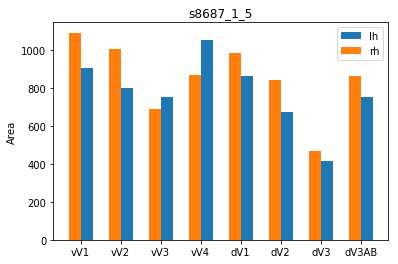

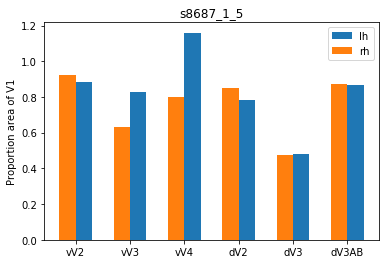

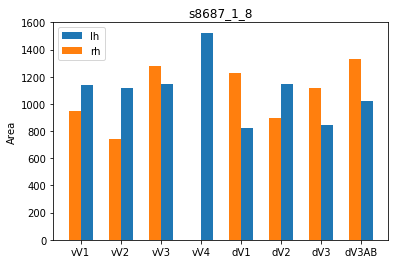

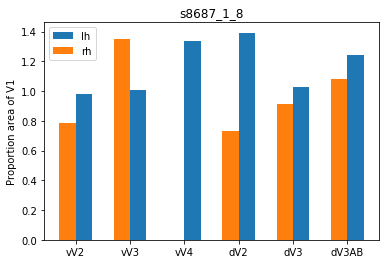

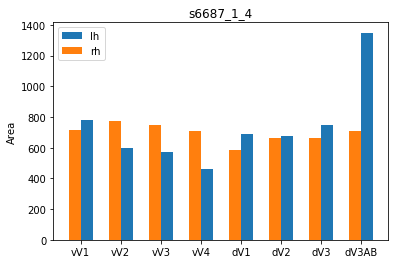

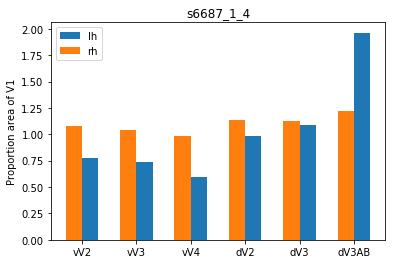

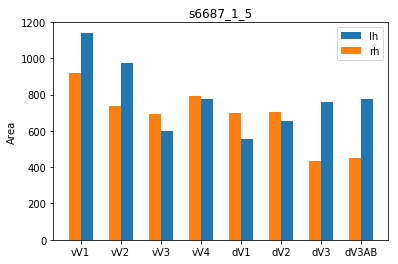

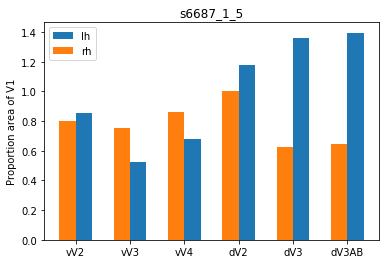

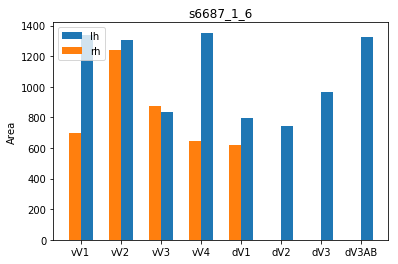

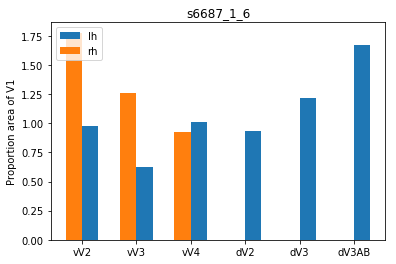

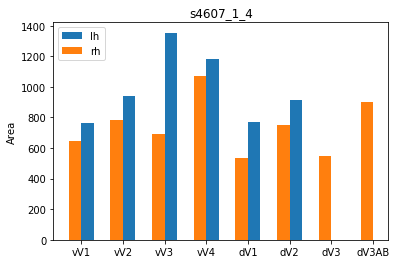

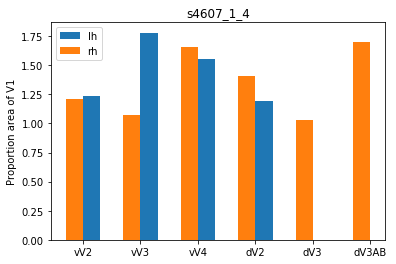

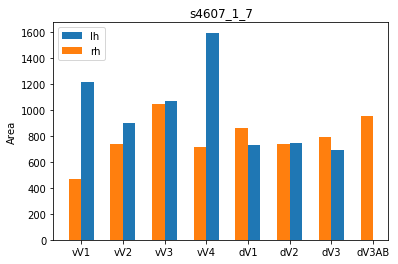

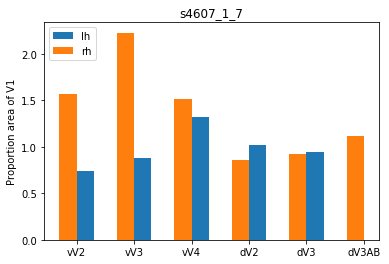

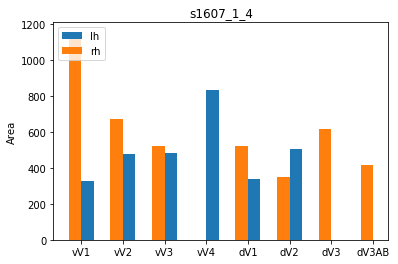

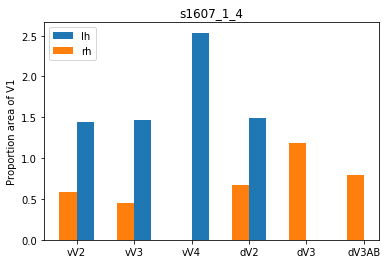

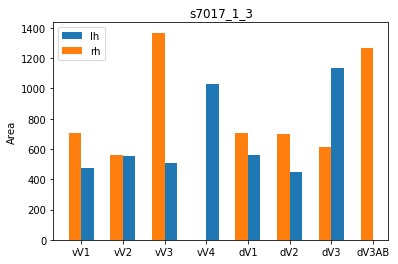

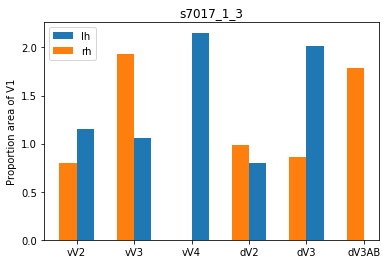

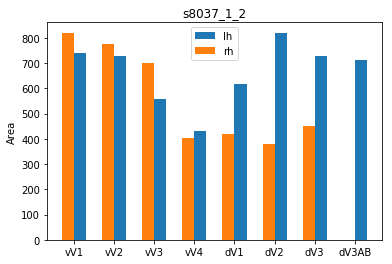

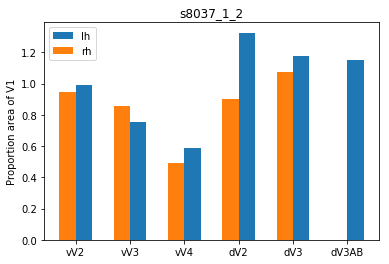

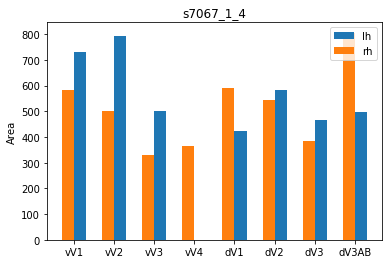

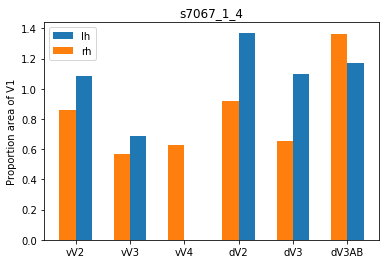

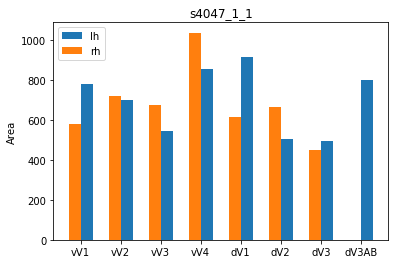

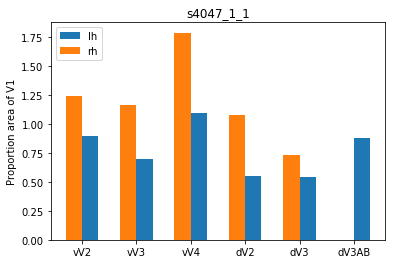

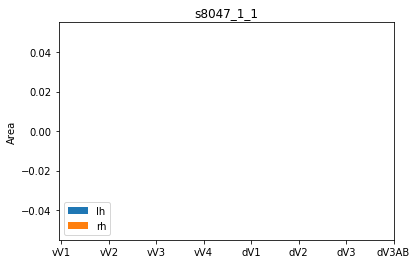

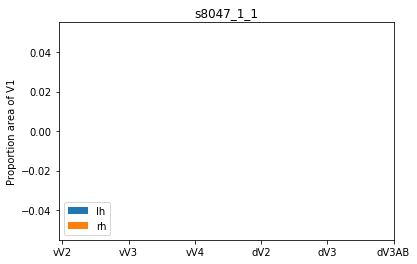

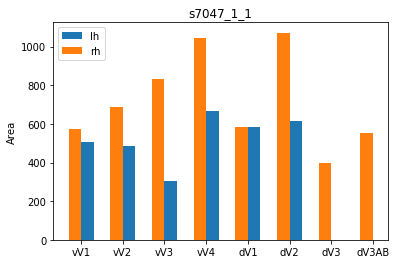

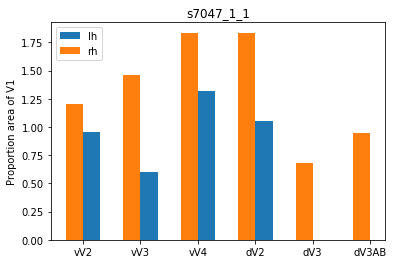

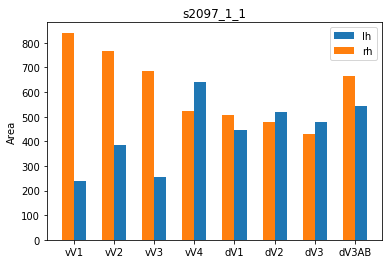

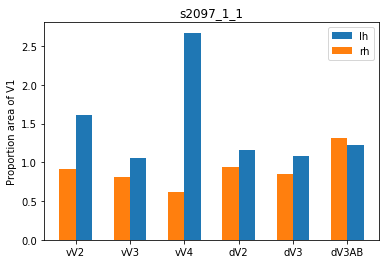

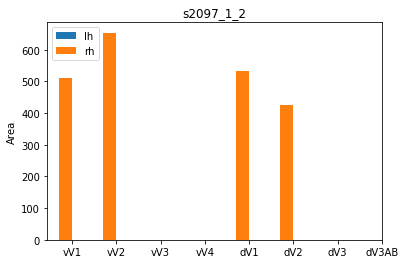

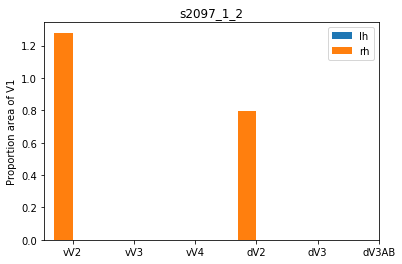

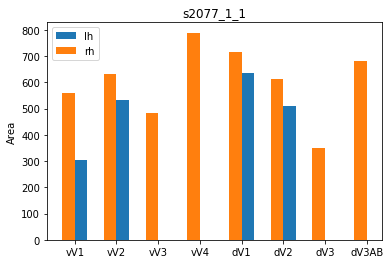

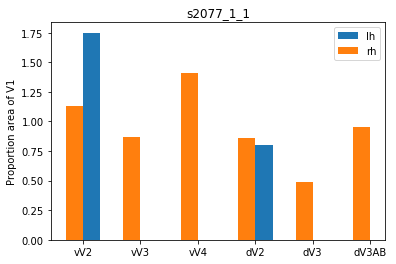

In [13]:
lh_area_df = pd.DataFrame(columns=['ID'] + rois)
rh_area_df = pd.DataFrame(columns=['ID'] + rois)
incl_ROIs = []

# Plot the data for the listed ppts individually and store the data
for ppt in df['ID']:
    
    print('\n\n%s' % ppt)
    # Get the area
    av_area = extract_av_area(ppt, use_uncertain_ROIs=use_uncertain_ROIs)
    
    # Store the data in a dictionary
    new_row = pd.Series([ppt] + av_area['lh'], index = lh_area_df.columns)
    lh_area_df = lh_area_df.append(new_row, ignore_index=True)    

    new_row = pd.Series([ppt] + av_area['rh'], index = rh_area_df.columns)
    rh_area_df = rh_area_df.append(new_row, ignore_index=True)    
    
    # Quantify the number of traced ROIs
    incl_ROIs += [np.sum(np.isnan(av_area['rh']) == False) + np.sum(np.isnan(av_area['lh']) == False)] 
    
    # Plot the data normalized to V1
    plot_ROIs(av_area, normalize_to_V1=0)
    plt.title(ppt)
    plt.savefig('%s/av_%s_area_bar_plots.svg' % (plot_dir, ppt)) 
    
    # Plot the raw area
    plot_ROIs(av_area, normalize_to_V1=1)
    plt.title(ppt)
    plt.savefig('%s/prop_%s_area_bar_plots.svg' % (plot_dir, ppt))
    

    

**Quantify how many ROIs you traced (out of 16) as it relates to the participant age and block number** 

Mean ROIs per participant: 13.118
Mean ROIs per hemisphere: 6.559


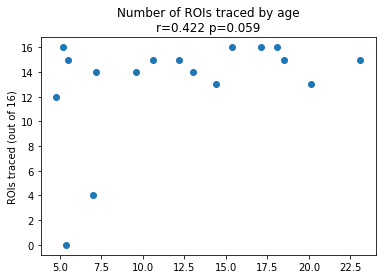

In [14]:
# Make summaries of the number of each ROI and as it relates to age and block number

plt.figure()
plt.scatter(df['Age'], incl_ROIs)
r_val = np.corrcoef(df['Age'], incl_ROIs)[0, 1]
p_val = randomise_corr(df['Age'], incl_ROIs)
plt.title('Number of ROIs traced by age\nr=%0.3f p=%0.3f' % (r_val, p_val))
plt.ylabel('ROIs traced (out of 16)')
print('Mean ROIs per participant: %0.3f' % np.mean(incl_ROIs))
print('Mean ROIs per hemisphere: %0.3f' % (np.mean(incl_ROIs) / 2))

Text(0.5, 0, 'Number of phases')

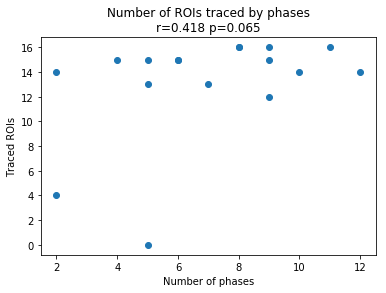

In [15]:
plt.figure()
plt.scatter(df['Vertical phases'] + df['Horizontal phases'], incl_ROIs)
r_val = np.corrcoef(df['Vertical phases'] + df['Horizontal phases'], incl_ROIs)[0, 1]
p_val = randomise_corr(df['Vertical phases'] + df['Horizontal phases'], incl_ROIs)
plt.title('Number of ROIs traced by phases\nr=%0.3f p=%0.3f' % (r_val, p_val))
plt.ylabel('Traced ROIs')
plt.xlabel('Number of phases')


**Compute the length of each ROI and store akin to area**
Use the pairwise distance of points lying on a line perpendicular to the region boundaries as a measure of length. These pairwise differences were computed using `SurfDist`.

In [16]:
# Preset
lh_length_df = pd.DataFrame(np.nan, index=np.arange(len(df['ID'])), columns=['ID'] + rois)
rh_length_df = pd.DataFrame(np.nan, index=np.arange(len(df['ID'])), columns=['ID'] + rois)

# Add the IDs to the dfs
lh_length_df['ID'] = list(df['ID'])
rh_length_df['ID'] = list(df['ID'])

# Get the vectors of each line drawn

for hemi in ['lh', 'rh']:
    for ROI_counter, roi in enumerate(rois):
        
        av_line_length = []
        for ppt in df['ID']:
            
            # Pull out the first letter as an index (either v or d)
            prefix = roi[0]

            # Specify the file with lines
            lines_file = '%s/iBEAT/%s/SUMA/%s%s.lines.niml.roi' % (data_dir, ppt, prefix, hemi)

            if os.path.exists(lines_file):

                # Load the roi file (different format)
                line_vecs = load_roi(lines_file)

                # Get the file names
                padded_1D_file = '%s/iBEAT/%s/SUMA/%s.manual_padded.1D.dset' % (data_dir, ppt, hemi)
                flat_map_file = '%s/iBEAT/%s/SUMA/%s.full.flat.patch.3d.asc' % (data_dir, ppt, hemi)

                # Print the nodes that overlap between two files or arrays
                ROIs_array = load_1D(padded_1D_file, expected_length=-1)
                nodes, _ = np.where(ROIs_array == (ROI_counter + 1))

                # This step should be redundant but just in case, pull it out
                nodes = ROIs_array[nodes, 0]
                
                if len(nodes) > 0:
                
                    # Cycle through the lines
                    line_length = []
                    for line_counter, line_vec in enumerate(line_vecs):

                        # Get the file names
                        file_name = '%s.lines_%d_%s' % (hemi, line_counter, roi)
                        pairwise_file = '%s/iBEAT/%s/SUMA/ROI_%s.manual/%s_nodes.1D' % (data_dir, ppt, hemi, file_name)
                        dist_file = '%s/iBEAT/%s/SUMA/ROI_%s.manual/%s_distance.1D' % (data_dir, ppt, hemi, file_name)

                        # Check items in one list correspond to items in the other. The second should be shorter than the later
                        usable_nodes = []
                        for node in line_vec:
                            if node in nodes:
                                usable_nodes += [node]

                        # Does the dist file exist? If not then create it
                        if os.path.exists(dist_file) == 0:

                            # Open the text file
                            fid = open(pairwise_file,"w") 

                            # Get the first and second item in pair
                            for idx_counter in range(1, len(usable_nodes)):
                                from_node = usable_nodes[idx_counter - 1]
                                to_node = usable_nodes[idx_counter]

                                # Write the nodes to an output
                                fid.write('%d %d\n' % (from_node, to_node))

                            # Close file
                            fid.close()

                            # Compute the pairwise distance 
                            os.system('SurfDist -i %s -input %s > temp_%s.txt' % (flat_map_file, pairwise_file, file_name))        

                            # Pull out the distances
                            os.system('1dcat -sel [2] temp_%s.txt > %s' % (file_name, dist_file))
                            
                            os.system('rm -f temp_%s' % file_name)
                            
                        # Load the line lengths
                        pairwise_dist = np.loadtxt(dist_file)
                        
                        # Check that there are pairwise distances
                        if np.sum(pairwise_dist.shape) > 0:
                            line_length += [np.sum(pairwise_dist)]
                        else:
                            line_length += [np.nan]
                    
                    # What is the average line length
                    av_line_length += [np.nanmean(line_length)]
                else:
                    
                    av_line_length += [np.nan]
                
            else:
                av_line_length += [np.nan]

        # Store the length of the data
        if hemi == 'lh':
            lh_length_df[roi] = av_line_length
        else:
            rh_length_df[roi] = av_line_length
            

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: loadtxt: Empty input file: "/gpfs/milgram/pi/turk-browne/users/ce325/infant_neuropipe_fork_public/data/Retinotopy//iBEAT/s2097_1_1/SUMA/ROI_lh.manual/lh.lines_1_vV1_distance.1D"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: loadtxt: Empty input file: "/gpfs/milgram/pi/turk-browne/users/ce325/infant_neuropipe_fork_public/data/Retinotopy//iBEAT/s2097_1_1/SUMA/ROI_lh.manual/lh.lines_1_vV2_distance.1D"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: loadtxt: Empty input file: "/gpfs/milgram/pi/turk-browne/users/ce325/infant_neuropipe_fork_public/data/Retinotopy//iBEAT/s6687_1_6/SUMA/ROI_lh.manual/lh.lines_1_dV3_distance.1D"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launche

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: loadtxt: Empty input file: "/gpfs/milgram/pi/turk-browne/users/ce325/infant_neuropipe_fork_public/data/Retinotopy//iBEAT/s6687_1_6/SUMA/ROI_rh.manual/rh.lines_0_dV3_distance.1D"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: loadtxt: Empty input file: "/gpfs/milgram/pi/turk-browne/users/ce325/infant_neuropipe_fork_public/data/Retinotopy//iBEAT/s6687_1_6/SUMA/ROI_rh.manual/rh.lines_1_dV3_distance.1D"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: loadtxt: Empty input file: "/gpfs/milgram/pi/turk-browne/users/ce325/infant_neuropipe_fork_public/data/Retinotopy//iBEAT/s6687_1_6/SUMA/ROI_rh.manual/rh.lines_2_dV3_distance.1D"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launche

**Compute the wholebrain volume to use as a reference**

In [17]:
# Load the whole brain volume
wholebrain_vol = []
denominator = 100000 # If you don't divide by this then the numbers get put in a bad range
is_whole_brain_vol = 1 # what do you want to use for the reference in the partial correlation

if is_whole_brain_vol == 1:
    mask_name = 'mask'
else:
    mask_name = 'gm'

# Load the participant data
for ppt in df['ID']:
    vol = nib.load('%s/iBEAT/%s/mri/%s.nii.gz' % (data_dir, ppt, mask_name)).get_data()

    # How many voxels are in the wholebrain
    wholebrain_vol += [(vol.sum() * (0.9375 ** 3)) / 100000]

# Get the brain volume correlation    
slope, intercept = np.polyfit(df['Age'], np.asarray(wholebrain_vol) * denominator, 1)
r_val = np.corrcoef(df['Age'], np.asarray(wholebrain_vol))[0, 1]
p_val = randomise_corr(df['Age'], np.asarray(wholebrain_vol))

print('%s volume age correlation. b=%0.3f, r=%0.3f, p=%0.3f' % (mask_name, slope, r_val, p_val))    

mask volume age correlation. b=14763.585, r=0.804, p=0.000


**Correlate the size (length or area) with age for each ROI, both with and without normalization**  
Does this analysis both for each individual ROI collapsed across left and right, as well as the ROIs collapsed across ventral and dorsal.

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


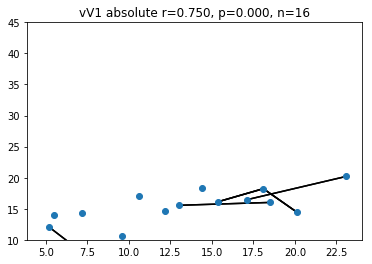

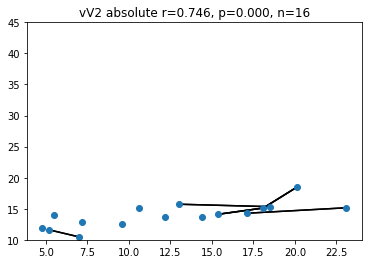

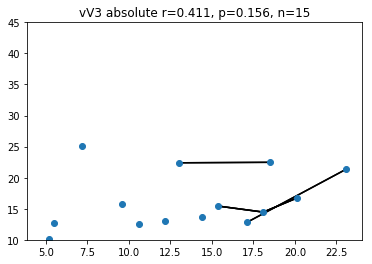

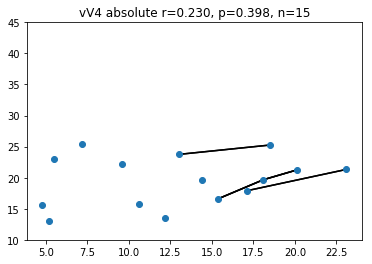

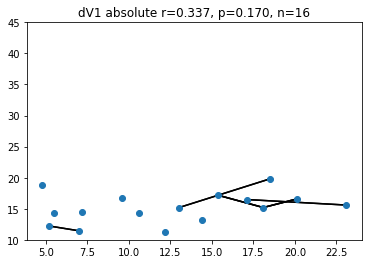

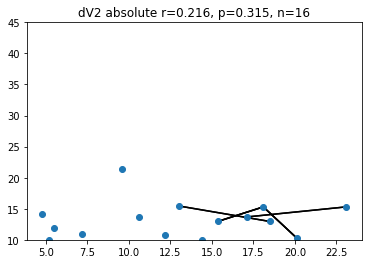

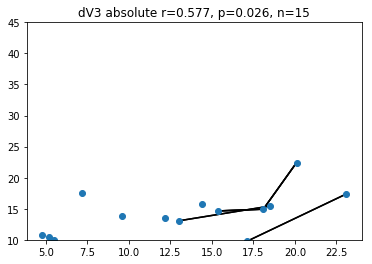

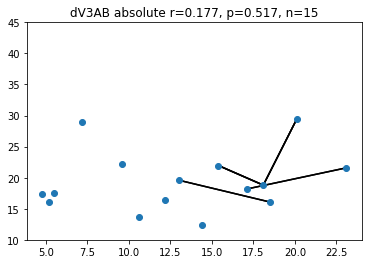

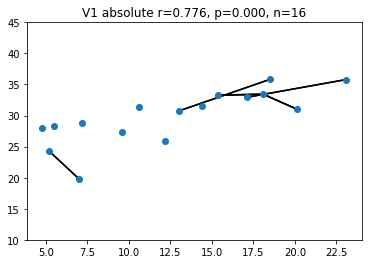

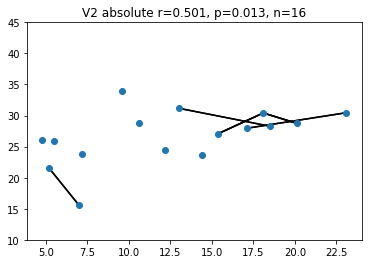

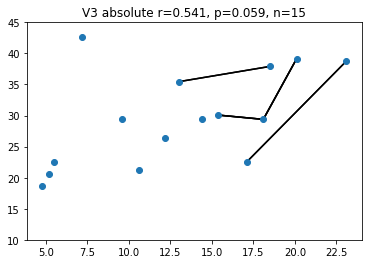

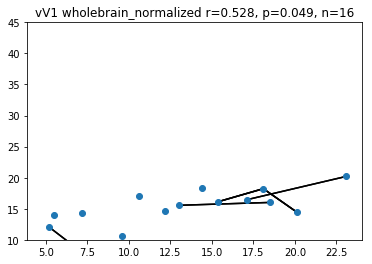

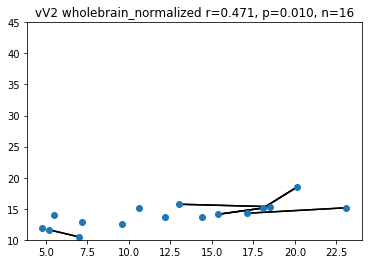

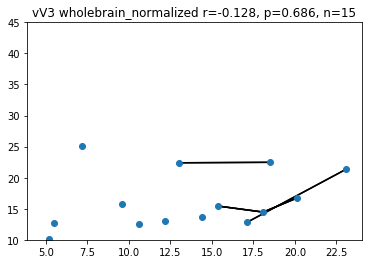

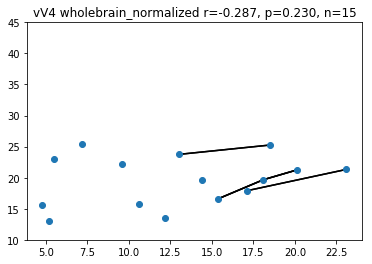

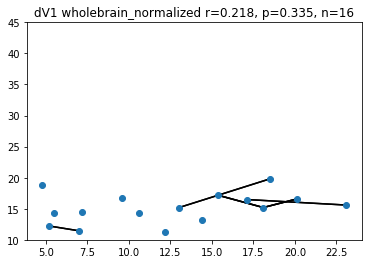

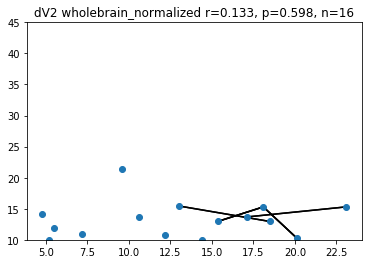

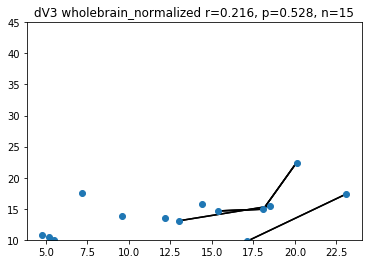

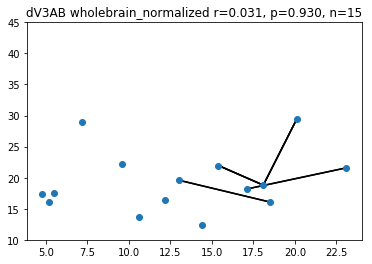

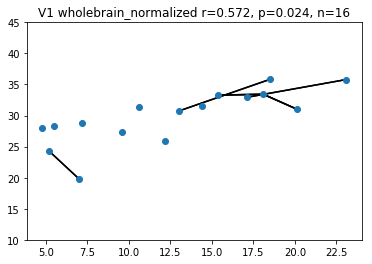

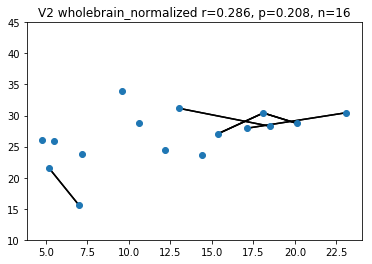

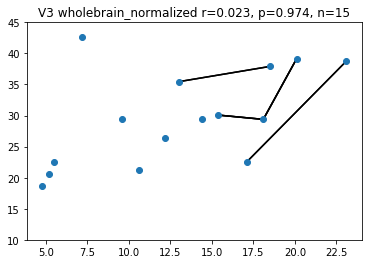

In [18]:
# Compute the volume relationship with age, averaging across hemispheres
use_area = 0

if use_area:
    metric_name = 'area'
    lh_df = lh_area_df
    rh_df = rh_area_df
    ylim = [0, 2500]
else:
    metric_name = 'length'
    lh_df = lh_length_df
    rh_df = rh_length_df
    ylim = [10, 45]

for normalize_to_V1, normal_str in enumerate(['absolute', 'wholebrain_normalized']):
    
    for roi in rois + ['V1', 'V2', 'V3']:
        plt.figure()

        # Compute the area of the ROIs (either normalizing to V1 or not)
        if roi[0] is 'v' or roi[0] is 'd':
            roi_area = np.nanmean((lh_df[roi], rh_df[roi]), axis=0)
        else:
            roi_area = np.nanmean((lh_df['v' + roi], rh_df['v' + roi]), axis=0) + np.nanmean((lh_df['d' + roi], rh_df['d' + roi]), axis=0)
            
        if normalize_to_V1 == 0:
            area_vals = roi_area
        elif normalize_to_V1 == 1:
            denominator = np.copy(wholebrain_vol)
            area_vals = roi_area
            
        plt.scatter(df['Age'], area_vals)
        plt.ylim(ylim)
        
        # Connect any IDs that are shared
        for ID_ppt in ID_ppts:
            tmp_area_vals = []
            tmp_age_vals = []
            for ID_counter, ID_session in enumerate(lh_df['ID']):

                # If the sessions match then add to the list for plotting
                if ID_session[:-2] == ID_ppt:

                    # Get area values
                    tmp_area_vals += [area_vals[ID_counter]]
                    tmp_age_vals += [list(df['Age'])[ID_counter]]

            plt.plot(tmp_age_vals, tmp_area_vals, 'k', zorder=0)

        # What is the correlation of the age and area (need to do ugly stuff to deal with the nans)
        x_vals = np.asarray(list(df['Age']))[np.isnan(area_vals) == 0]
        y_vals = roi_area[np.isnan(roi_area) == 0]
        if normalize_to_V1 == 0:
            corr_val = np.corrcoef(x_vals, y_vals)[0, 1]
            p_val = randomise_corr(x_vals, y_vals)
        else:
            cov_vals = denominator[np.isnan(roi_area) == 0]
            corr_val, _ = partial_corr(x_vals, y_vals, cov_vals)
            p_val = randomise_corr(x_vals, y_vals, cov_vals=cov_vals)
            
        plt.title('%s %s r=%0.3f, p=%0.3f, n=%d' % (roi, normal_str, corr_val, p_val, np.sum(np.isnan(area_vals) == 0)))
        plt.savefig('%s/prop_scatter_%s_%s_%s.svg' % (plot_dir, roi, normal_str, metric_name))
    

**Compare the size of adjacent regions**  
For instance, how much larger is V1 than V2

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


Mean length V1=29.905 [SD=4.127]
Mean length V2=26.744 [SD=4.228]
Percentage reduction = 0.897 [SD=0.111]
Diff of ROIs, CI = 1.432 4.657, p = 0.001
Mean length V1=29.905 [SD=4.127]
Mean length V3=29.615 [SD=7.438]
Percentage reduction = 0.968 [SD=0.221]
Diff of ROIs, CI = -2.504 4.157, p = 0.593
Mean length V2=26.744 [SD=4.228]
Mean length V3=29.615 [SD=7.438]
Percentage reduction = 1.084 [SD=0.279]
Diff of ROIs, CI = -5.888 1.402, p = 0.260


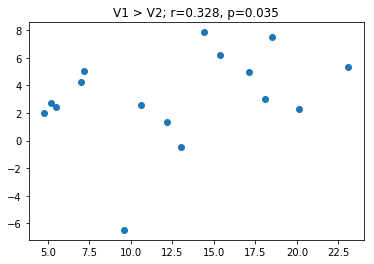

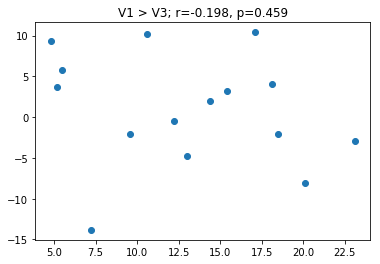

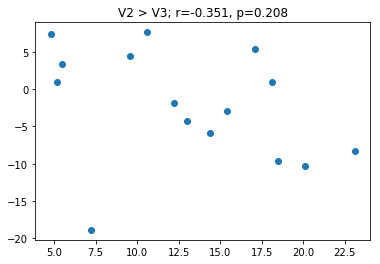

In [19]:
use_area = 0

if use_area:
    metric_name = 'area'
    lh_df = lh_area_df
    rh_df = rh_area_df
    ylim = [0, 2500]
else:
    metric_name = 'length'
    lh_df = lh_length_df
    rh_df = rh_length_df


for compare_ROI in [['V1', 'V2'], ['V1', 'V3'], ['V2', 'V3']]:

    # Get the ROI information
    ROI_1 = np.nanmean((lh_df['v' + compare_ROI[0]], rh_df['v' + compare_ROI[0]]), axis=0) + np.nanmean((lh_df['d' + compare_ROI[0]], rh_df['d' + compare_ROI[0]]), axis=0)
    ROI_2 = np.nanmean((lh_df['v' + compare_ROI[1]], rh_df['v' + compare_ROI[1]]), axis=0) + np.nanmean((lh_df['d' + compare_ROI[1]], rh_df['d' + compare_ROI[1]]), axis=0)
    
    # Report the summary information
    print('Mean %s %s=%0.3f [SD=%0.3f]' % (metric_name, compare_ROI[0], np.nanmean(ROI_1), np.nanstd(ROI_1)))
    print('Mean %s %s=%0.3f [SD=%0.3f]' % (metric_name, compare_ROI[1], np.nanmean(ROI_2), np.nanstd(ROI_2)))
    print('Percentage reduction = %0.3f [SD=%0.3f]' % (np.nanmean(ROI_2/ROI_1), np.nanstd(ROI_2/ROI_1)))
    diff_vals = ROI_1 - ROI_2
    p, _, CI = randomise_diff(diff_vals[np.isnan(diff_vals) == 0])
    print('Diff of ROIs, CI = %0.3f %0.3f, p = %0.3f' % (CI[0], CI[1], p))
    
    # See if there is a relationship with age
    plt.figure()
    plt.scatter(df['Age'], diff_vals)
    r_val = np.corrcoef(diff_vals[np.isnan(diff_vals) == 0], df['Age'][np.isnan(diff_vals) == 0])[0, 1]
    p_val = randomise_corr(diff_vals[np.isnan(diff_vals) == 0], df['Age'][np.isnan(diff_vals) == 0])
    plt.title('%s > %s; r=%0.3f, p=%0.3f' % (compare_ROI[0], compare_ROI[1], r_val, p_val))
    
    

**Are the sizes of regions consistent within individual?**  
Correlate the size of the regions between hemispheres and between dorsal/ventral

In [20]:
use_area = 0

if use_area:
    lh_df = lh_area_df
    rh_df = rh_area_df
else:
    metric_name = 'length'
    lh_df = lh_length_df
    rh_df = rh_length_df
    

for roi in rois:
    
    usable_ppts = (np.isnan(lh_df[roi]) == 0) & (np.isnan(rh_df[roi]) == 0)
    rval = np.corrcoef(lh_df[roi][usable_ppts], rh_df[roi][usable_ppts])[0, 1]
    pval = randomise_corr(lh_df[roi][usable_ppts], rh_df[roi][usable_ppts])
    print('Correlation between left and right hemisphere for %s: r=%0.3f p=%0.3f' % (roi, rval, pval))
    
for roi in ['V1', 'V2', 'V3']:
    
    ventral = np.nanmean((lh_df['v' + roi], rh_df['v' + roi]), 0)
    dorsal = np.nanmean((lh_df['d' + roi], rh_df['d' + roi]), 0)
    usable_ppts = (np.isnan(ventral) == 0) & (np.isnan(dorsal) == 0)
    
    rval = np.corrcoef(ventral[usable_ppts], dorsal[usable_ppts])[0, 1]
    pval = randomise_corr(ventral[usable_ppts], dorsal[usable_ppts])
    print('Correlation between ventral and dorsal %s: r=%0.3f p=%0.3f' % (roi, rval, pval))
    

Correlation between left and right hemisphere for vV1: r=0.003 p=0.969
Correlation between left and right hemisphere for vV2: r=-0.016 p=0.931
Correlation between left and right hemisphere for vV3: r=0.212 p=0.244
Correlation between left and right hemisphere for vV4: r=0.516 p=0.101
Correlation between left and right hemisphere for dV1: r=0.126 p=0.657
Correlation between left and right hemisphere for dV2: r=0.247 p=0.543
Correlation between left and right hemisphere for dV3: r=0.393 p=0.106
Correlation between left and right hemisphere for dV3AB: r=0.311 p=0.575


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


Correlation between ventral and dorsal V1: r=0.075 p=0.796
Correlation between ventral and dorsal V2: r=0.228 p=0.489
Correlation between ventral and dorsal V3: r=0.576 p=0.001


**Make a table of the region size that can be read by latex**  

In [21]:
# What are the keys you want from the table and what are their formats
use_area = 0

if use_area:
    metric_name = 'area'
    lh_df = lh_area_df
    rh_df = rh_area_df
    num_format = '%0.0f'
else:
    metric_name = 'length'
    lh_df = lh_length_df
    rh_df = rh_length_df
    num_format = '%0.1f'

# Get the keys to read out    
key_formats = {}
for key in lh_df.keys()[1:]:
    key_formats[key] = num_format
key_formats['V1'] = num_format
key_formats['V2'] = num_format
key_formats['V3'] = num_format
    
# Resort the idxs by age
resorted_idxs = np.argsort(df['Age'])

print_str = 'ID'
for key in key_formats.keys():
    print_str += ' & ' + key

print_str += '\\\\'    
print(print_str)

for ppt_idx in resorted_idxs:
    
    # What is the ID for this participant 
    print_str = lh_df['ID'][ppt_idx]
    for key in key_formats.keys():
        
        if key[0] == 'v' or key[0] == 'd':
            key_val = np.nanmean((lh_df[key][ppt_idx], rh_df[key][ppt_idx]))
        else:
            key_val = np.nanmean((lh_df['v' + key][ppt_idx], rh_df['v' + key][ppt_idx])) + np.nanmean((lh_df['d' + key][ppt_idx], rh_df['d' + key][ppt_idx]))
            
        # Append to the string differently if it is a string or num
        print_str += (' & ' + key_formats[key]) % key_val
    
    print_str += '\\\\'
    
    print(print_str)

# Print an extra row of the means
print('\hline')
print_str = 'Av.'
for key in key_formats.keys():
    
    if key[0] == 'v' or key[0] == 'd':
        key_val = np.nanmean(np.nanmean((lh_df[key], rh_df[key]), 0))
    else:
        key_val = np.nanmean(np.nanmean((lh_df['v' + key], rh_df['v' + key]), 0) + np.nanmean((lh_df['d' + key], rh_df['d' + key]), 0))

    key_format = '%0.2f'
    
    # Append to the string differently if it is a string or num
    print_str += (' & ' + key_format) % key_val

print_str += '\\\\'
print(print_str)
    

ID & vV1 & vV2 & vV3 & vV4 & dV1 & dV2 & dV3 & dV3AB & V1 & V2 & V3\\
s2077_1_1 & 9.1 & 11.9 & 7.8 & 15.7 & 18.9 & 14.1 & 10.8 & 17.3 & 28.0 & 26.0 & 18.7\\
s2097_1_1 & 12.1 & 11.6 & 10.2 & 13.1 & 12.2 & 9.9 & 10.4 & 16.1 & 24.3 & 21.6 & 20.5\\
s8047_1_1 & nan & nan & nan & nan & nan & nan & nan & nan & nan & nan & nan\\
s4047_1_1 & 13.9 & 14.0 & 12.6 & 23.1 & 14.4 & 11.9 & 9.9 & 17.6 & 28.3 & 25.9 & 22.6\\
s2097_1_2 & 8.4 & 10.5 & nan & nan & 11.5 & 5.1 & nan & nan & 19.8 & 15.6 & nan\\
s7017_1_3 & 14.3 & 12.8 & 25.2 & 25.4 & 14.6 & 11.0 & 17.5 & 29.0 & 28.8 & 23.8 & 42.6\\
s7047_1_1 & 10.7 & 12.6 & 15.7 & 22.1 & 16.8 & 21.3 & 13.8 & 22.2 & 27.4 & 33.9 & 29.5\\
s7067_1_4 & 17.1 & 15.2 & 12.6 & 15.7 & 14.3 & 13.6 & 8.6 & 13.6 & 31.4 & 28.8 & 21.2\\
s8037_1_2 & 14.6 & 13.7 & 12.9 & 13.6 & 11.3 & 10.8 & 13.4 & 16.4 & 25.9 & 24.5 & 26.4\\
s4607_1_4 & 15.6 & 15.7 & 22.4 & 23.7 & 15.2 & 15.5 & 13.1 & 19.6 & 30.7 & 31.2 & 35.4\\
s1607_1_4 & 18.4 & 13.8 & 13.7 & 19.7 & 13.1 & 9.9 & 15.8 & 12.

<input>:52: DeprecationWarning: invalid escape sequence \h
<ipython-input-21-0d967dabe9bb>:52: DeprecationWarning: invalid escape sequence \h
  print('\hline')
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


**Is foveal confluence area varying with age?**  
It is possible that older or younger kids have larger foveal confluence. To test this, the regions connecting the dorsal and ventral regions were traced and are loaded in here. This analysis also compares the size with the proportion of usable looking time



s8687_1_5


s8687_1_8


s6687_1_4


s6687_1_5


s6687_1_6
Missing rh V2
Missing rh V3


s4607_1_4
Missing lh V3


s4607_1_7


s1607_1_4
Missing lh V3


s7017_1_3


s8037_1_2


s7067_1_4


s4047_1_1


s8047_1_1
Missing lh V1
Missing lh V2
Missing lh V3
Missing rh V1
Missing rh V2
Missing rh V3


s7047_1_1
Missing lh V3


s2097_1_1


s2097_1_2
Missing lh V1
Missing lh V2
Missing lh V3
Missing rh V3


s2077_1_1
Missing lh V3


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


V1 correlation with age: r=0.84 p=0.000


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))


V1 partial correlation with age: r=0.75 p=0.001
V1 correlation with looking time: r=-0.36 p=0.070
V1 between area divided by ventral + dorsal area correlation with age: r=0.32 p=0.054
V2 correlation with age: r=0.68 p=0.009
V2 partial correlation with age: r=0.51 p=0.066
V2 correlation with looking time: r=-0.25 p=0.212
V2 between area divided by ventral + dorsal area correlation with age: r=0.15 p=0.559
V3 correlation with age: r=0.70 p=0.004
V3 partial correlation with age: r=0.36 p=0.182
V3 correlation with looking time: r=-0.15 p=0.439
V3 between area divided by ventral + dorsal area correlation with age: r=0.24 p=0.282
all correlation with age: r=0.77 p=0.001
all partial correlation with age: r=0.54 p=0.021
all correlation with looking time: r=-0.21 p=0.280


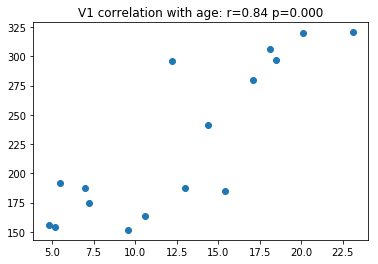

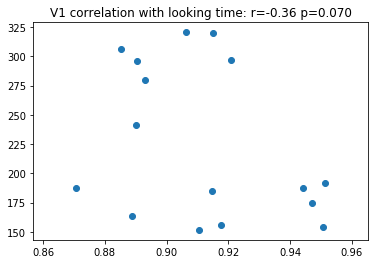

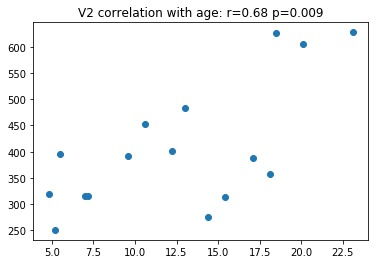

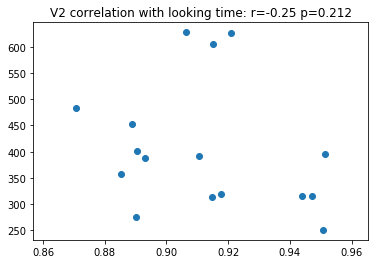

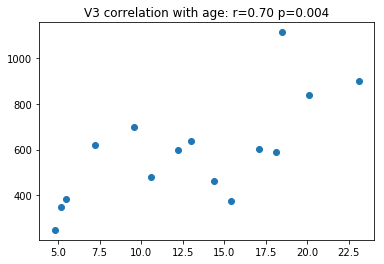

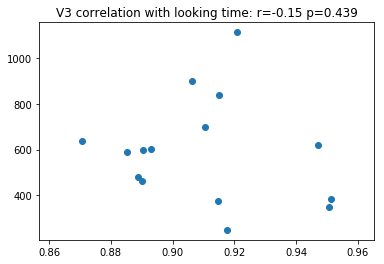

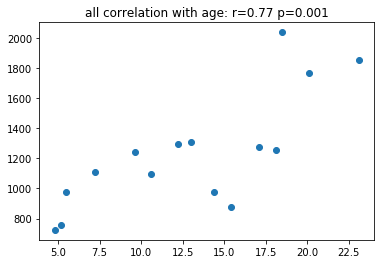

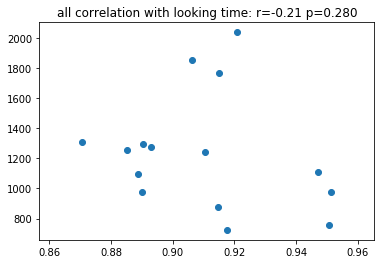

In [22]:
av_area_size = np.zeros((len(df['ID']), 3)) * np.nan

for ppt_counter, ppt in enumerate(df['ID']):
    
    print('\n\n%s' % ppt)
    # Get the area
    av_area_between = extract_av_area_between(ppt)
    
    # What is the average size of the area between regions
    av_area_size[ppt_counter, :] = np.nanmean(np.vstack((av_area_between['lh'], av_area_between['rh'])), 0)

# Cycle through the ROIs and compute the relationship
for roi_counter, roi in enumerate(['V1', 'V2', 'V3', 'all']):
    
    # get the specific region
    if roi == 'all':
        av_area_vals = np.sum(av_area_size, 1)
    else:
        av_area_vals = av_area_size[:, roi_counter]    
    
    # What participants are usable
    usable_ppts = np.isnan(av_area_vals) == 0
    
    rval = np.corrcoef(av_area_vals[usable_ppts], np.asarray(list(df['Age']))[usable_ppts])[0, 1]
    pval = randomise_corr(av_area_vals[usable_ppts], np.asarray(list(df['Age']))[usable_ppts])
    
    print('%s correlation with age: r=%0.2f p=%0.3f' % (roi, rval, pval))
    plt.figure()
    plt.scatter(np.asarray(list(df['Age']))[usable_ppts], av_area_vals[usable_ppts])
    plt.title('%s correlation with age: r=%0.2f p=%0.3f' % (roi, rval, pval))
    
    rval = partial_corr(av_area_vals[usable_ppts], np.asarray(list(df['Age']))[usable_ppts], np.asarray(wholebrain_vol)[usable_ppts])
    pval = randomise_corr(av_area_vals[usable_ppts], np.asarray(list(df['Age']))[usable_ppts], cov_vals=np.asarray(wholebrain_vol)[usable_ppts])

    print('%s partial correlation with age: r=%0.2f p=%0.3f' % (roi, rval[0], pval))
    
    rval = np.corrcoef(av_area_vals[usable_ppts], np.asarray(list(df['prop_eye_included']))[usable_ppts])[0, 1]
    pval = randomise_corr(av_area_vals[usable_ppts], np.asarray(list(df['prop_eye_included']))[usable_ppts])
    
    print('%s correlation with looking time: r=%0.2f p=%0.3f' % (roi, rval, pval))
    plt.figure()
    plt.scatter(np.asarray(list(df['prop_eye_included']))[usable_ppts], av_area_vals[usable_ppts])    
    plt.title('%s correlation with looking time: r=%0.2f p=%0.3f' % (roi, rval, pval))
    
    
    # Determine if the area in the foveal confluence correlates with age by taking the area of each foveal region as a proportion of the ventral + dorsal area    
    if roi != 'all':
        ventral = np.nanmean(np.vstack((lh_area_df['v' + roi], rh_area_df['v' + roi])), 0)
        dorsal = np.nanmean(np.vstack((lh_area_df['d' + roi], rh_area_df['d' + roi])), 0)
        
        proportion_area = av_area_size[:, roi_counter] / np.sum(np.vstack((ventral, dorsal)), 0)
        usable_ppts = np.isnan(proportion_area)==0
        rval = np.corrcoef(np.asarray(list(df['Age']))[usable_ppts], proportion_area[usable_ppts])[0, 1]
        pval = randomise_corr(np.asarray(list(df['Age']))[usable_ppts], proportion_area[usable_ppts])

        print('%s between area divided by ventral + dorsal area correlation with age: r=%0.2f p=%0.3f' % (roi, rval, pval))

    

## Compute DICE similiarity
First compute the similarity of each individual to the Wang, Mruczek, Arcaro, Kastner (2015) atlas standard

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:235: RuntimeWarning: invalid value encountered in long_scalars
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


Mean DICE: 0.389 [SD=0.084]


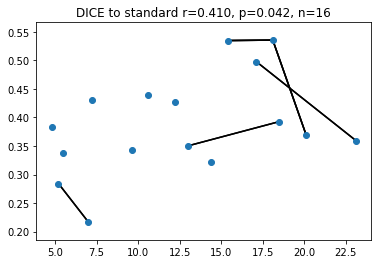

In [23]:
# Compute the similarity between each individual participant and the standard brain
constrained_idxs = -1 # [1, 5] # If you want to use a subset of idxs then can specify that here (can be a list), otherwise say -1

# Reset
np.random.seed(0)    

DICE_std_all = {}
for hemi in ['lh', 'rh']:
    
    DICE_std_all[hemi] = []
    for ppt in df['ID']:
        
        # Load in the standard space surface data (it gets relabelled by the lines below so just rerun it here)
        std_file = '%s/masks/maxprob_surf_%s.std141.1D.dset' % (data_dir, hemi)
        std_vec = load_1D(std_file)

        # Relabel the vector to match the number system used here
        std_vec = convert_std_vec(std_vec, Wang2manual)

        roi_file = '%s//iBEAT/%s/SUMA/std.141.%s.manual.1D' % (data_dir, ppt, hemi)

        # Load in the vector files 
        if os.path.exists(roi_file):
            roi_vec = load_1D(roi_file)
            
            if np.all(roi_vec == -1):
                # If the file doesn't exist, store a nan
                DICE_std_all[hemi] += [np.nan]
            else:
                # Which values overlap between vecs
                relevant_idxs = np.intersect1d(np.unique(roi_vec), np.unique(std_vec))

                # Constrain the indexes if specified
                if constrained_idxs != -1:
                    relevant_idxs = np.intersect1d(relevant_idxs, constrained_idxs)

                # Compute the DICE for these vecs
                DICE_std_all[hemi] += [compute_DICE_1D(roi_vec, std_vec, relevant_idxs)]
            
        else:
            # If the file doesn't exist, store a nan
            DICE_std_all[hemi] += [np.nan]
                
# Plot the relationship between DICE score with standard and age
vals = np.nanmean((DICE_std_all['lh'], DICE_std_all['rh']), axis=0)

plt.scatter(df['Age'], vals)

# Connect any IDs that are shared
for ID_ppt in ID_ppts:
    tmp_vals = []
    tmp_age_vals = []
    for ID_counter, ID_session in enumerate(df['ID']):

        # If the sessions match then add to the list for plotting
        if ID_session[:-2] == ID_ppt:

            # Get area values
            tmp_vals += [vals[ID_counter]]
            tmp_age_vals += [list(df['Age'])[ID_counter]]

    plt.plot(tmp_age_vals, tmp_vals, 'k', zorder=0)
    
corr_val = np.corrcoef(np.asarray(list(df['Age']))[np.isnan(vals) == 0], vals[np.isnan(vals) == 0])[0, 1]
p_val = randomise_corr(np.asarray(list(df['Age']))[np.isnan(vals) == 0], vals[np.isnan(vals) == 0])

# Report the title and save the data
if constrained_idxs == -1:
    plt.title('DICE to standard r=%0.3f, p=%0.3f, n=%d' % (corr_val, p_val, np.sum(np.isnan(vals) == 0)))            
    plt.savefig('%s/DICE_to_standard.svg' % (plot_dir))

else:
    plt.title('DICE to standard r=%0.3f, p=%0.3f, n=%d, constrained: ' % (corr_val, p_val, np.sum(np.isnan(vals) == 0)) + str(constrained_idxs))            
    plt.savefig('%s/DICE_to_standard_%s.svg' % (plot_dir, str(constrained_idxs)))    
    
print('Mean DICE: %0.3f [SD=%0.3f]' % (np.nanmean(vals), np.nanstd(vals)))

**Compute the DICE between each participant, making a grid of participant by participant DICE values**

In [24]:
# Compute the similarity between all individuals with each other
DICE_ppts_all = {}
for hemi in ['lh', 'rh']:
    
    input_file = '%s/DICE_btwn_ppts_%s.npy' % (data_dir, hemi)
    
    if os.path.exists(input_file) == 0:

        DICE_ppts_all[hemi] = np.zeros((len(df['ID']), len(df['ID'])))
        for ppt_1_counter, ppt_1 in enumerate(df['ID']):
            print('Progress for %s: %0.2f %%' % (hemi, ppt_1_counter * 100 / len(df['ID'])))
            for ppt_2_counter, ppt_2 in enumerate(df['ID']):

                # Exclude the diagonal (Could instead only include the lower diagonal)
                if ppt_1_counter != ppt_2_counter: # ppt_1_counter > ppt_2_counter:

                    ppt_1_file = '%s/iBEAT/%s/SUMA/std.141.%s.manual.1D' % (data_dir, ppt_1, hemi)
                    ppt_2_file = '%s/iBEAT/%s/SUMA/std.141.%s.manual.1D' % (data_dir, ppt_2, hemi)

                    if os.path.exists(ppt_1_file) and os.path.exists(ppt_2_file):

                        # Load in the vector files
                        ppt_1_vec = load_1D(ppt_1_file)
                        ppt_2_vec = load_1D(ppt_2_file)

                        # Which values overlap between vecs
                        relevant_idxs = np.intersect1d(np.unique(ppt_1_vec), np.unique(ppt_2_vec))

                        # Compute the DICE for these vecs
                        DICE_ppts_all[hemi][ppt_1_counter, ppt_2_counter] = compute_DICE_1D(ppt_1_vec, ppt_2_vec, relevant_idxs)
                    else:
                        DICE_ppts_all[hemi][ppt_1_counter, ppt_2_counter] = np.nan

                else:
                    DICE_ppts_all[hemi][ppt_1_counter, ppt_2_counter] = np.nan

        # Save the matrix
        np.save(input_file, DICE_ppts_all[hemi])
        
    else:
        DICE_ppts_all[hemi] = np.load(input_file)

**Use the participant DICE grid to compare across participants and visualize**

Rank of repeated session particpants, out of 17
Out of s2097_1_1 comparisons, rank of comparison to s2097_1_2, (age diff=1.8): 2
Out of s2097_1_2 comparisons, rank of comparison to s2097_1_1, (age diff=1.8): 3
Out of s4607_1_4 comparisons, rank of comparison to s4607_1_7, (age diff=5.5): 0
Out of s6687_1_4 comparisons, rank of comparison to s6687_1_5, (age diff=2.7): 0
Out of s6687_1_4 comparisons, rank of comparison to s6687_1_6, (age diff=4.7): 3
Out of s8687_1_5 comparisons, rank of comparison to s8687_1_8, (age diff=6.0): 1
Out of s6687_1_5 comparisons, rank of comparison to s6687_1_4, (age diff=2.7): 0
Out of s6687_1_5 comparisons, rank of comparison to s6687_1_6, (age diff=2.0): 1
Out of s4607_1_7 comparisons, rank of comparison to s4607_1_4, (age diff=5.5): 0
Out of s6687_1_6 comparisons, rank of comparison to s6687_1_4, (age diff=4.7): 0
Out of s6687_1_6 comparisons, rank of comparison to s6687_1_5, (age diff=2.0): 1
Out of s8687_1_8 comparisons, rank of comparison to s8687_1_5

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less



Average rank = 1.000
p value of real rank relative to shuffled rank: p=0.000
Average age difference of participants who are lower rank: 6.350


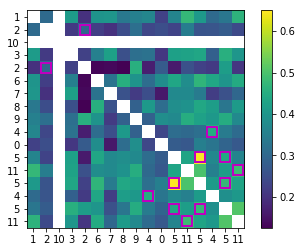

In [25]:
# Connect any IDs that are shared
ID_nums = []
for session_counter, ID_session in enumerate(df['ID']):
    for ID_counter, ID_ppt in enumerate(np.unique(ID_ppts)):
    
        # If the sessions match then add to the list for plotting
        if ID_session[:-2] == ID_ppt:

            # Get ID numbers for each participant
            ID_nums += [ID_counter]


# Reorder the nums to be ordered by age   
age_ordered_idx = np.argsort(list(df['Age']))
ID_nums = np.asarray(ID_nums)[age_ordered_idx]            
            
average_mat_unordered = np.nanmean(np.dstack((DICE_ppts_all['rh'], DICE_ppts_all['lh'])), axis=2)

for i in range(17):
    average_mat_unordered[i, i] = np.nan
    
# Reorder average_mat 
average_mat = np.zeros(average_mat_unordered.shape)
for idx_1_counter, idx_1 in enumerate(age_ordered_idx):
    for idx_2_counter, idx_2 in enumerate(age_ordered_idx):
        average_mat[idx_1_counter, idx_2_counter] = average_mat_unordered[idx_1, idx_2]
    
plt.imshow(average_mat)  

plt.xticks(np.arange(len(ID_nums)), ID_nums)
plt.yticks(np.arange(len(ID_nums)), ID_nums)
#plt.xticks(np.arange(len(ID_nums)), np.asarray(df['Age'])[age_ordered_idx])
#plt.yticks(np.arange(len(ID_nums)), np.asarray(df['Age'])[age_ordered_idx])


# Check if there are sessions who are the same participant, if so, plot it and store those results
repeat_sessions = []
for ppt_1_counter, ppt_1 in enumerate(ID_nums):
    for ppt_2_counter, ppt_2 in enumerate(ID_nums):
        if ppt_1 == ppt_2 and np.isnan(average_mat[ppt_1_counter, ppt_2_counter]) == False:
            
            # Make a purple dot
            plt.plot(ppt_1_counter, ppt_2_counter, marker='s', color='m', markeredgewidth = 2, markersize=10, fillstyle ='none')
            
            # Store the data relevant for the comparison
            ppt_1_id = [np.asarray(df['ID'])[age_ordered_idx][ppt_1_counter]]
            ppt_2_id = [np.asarray(df['ID'])[age_ordered_idx][ppt_2_counter]]
            av_val = [average_mat[ppt_1_counter, ppt_2_counter]]
            other_av_val = [average_mat[np.asarray(ID_nums) != ppt_1, ppt_2_counter]]
            age_diff = [abs(np.asarray(df['Age'])[age_ordered_idx][ppt_1_counter] - np.asarray(df['Age'])[age_ordered_idx][ppt_2_counter])]
            other_age_diffs = [np.asarray(df['Age'])[age_ordered_idx][ppt_1_counter] - np.asarray(df['Age'])[age_ordered_idx][np.asarray(ID_nums) != ppt_1]]
            within_vs_between = [ppt_1_id, ppt_2_id, av_val, other_av_val, age_diff, other_age_diffs]
            repeat_sessions += [within_vs_between]
        
                
# Get the number of other participants that have higher DICE than the matching session  
print('Rank of repeated session particpants, out of %d' % len(ID_nums))
rank_vals = []
rank_denominators = []
higher_age_diffs = []
for repeat_session in repeat_sessions:
    
    # Identify all other other sessions that are higher rank
    other_higher = (repeat_session[2][0] - repeat_session[3][0]) < 0
    higher_age_diffs += list(np.asarray(repeat_session[5][0])[other_higher])
    
    # How many of the participants within a smaller age range than the sessions being compared
    #print(np.sum(abs(np.asarray(repeat_session[5][0])[other_higher]) < repeat_session[4][0]))
    
    rank = np.sum(other_higher)
    rank_vals += [rank]
    rank_denominators += [len(repeat_session[3][0])]
    print('Out of %s comparisons, rank of comparison to %s, (age diff=%0.1f): %d' % (repeat_session[0][0], repeat_session[1][0], repeat_session[4][0], rank))                
    
shuffled_rank = []
for shuffle_counter in range(10000):
    shuffled_ranks = []
    for rank_denominator in rank_denominators:
        shuffled_ranks += [np.random.randint(0, rank_denominator)]
    shuffled_rank += [np.mean(shuffled_ranks)]
    
p_val = np.mean(shuffled_rank  < np.mean(rank_vals))

print('\nAverage rank = %0.3f' % np.mean(rank_vals))
print('p value of real rank relative to shuffled rank: p=%0.3f' % p_val)

print('Average age difference of participants who are lower rank: %0.3f' % np.mean(np.abs(higher_age_diffs)))

plt.colorbar()
    
plt.savefig('%s/intersubject_similarity.svg' % (plot_dir))    
    

**Use the participant matrix to  test how similar the repeat sessions are to other participants**  
This analysis uses all comparisons with other participants for comparison, and then runs an independent samples test

In [26]:
repeat_session = []
non_repeat_session = []
ppt_score_avgs = []
for ppt_1_counter, ppt_1 in enumerate(ID_nums):
    ppt_scores = []
    for ppt_2_counter, ppt_2 in enumerate(ID_nums):
        if (ppt_1_counter > ppt_2_counter) and (np.isnan(average_mat[ppt_1_counter, ppt_2_counter]) == False):
            
            # Store the participant
            if ppt_1 == ppt_2:
                repeat_session += [average_mat[ppt_1_counter, ppt_2_counter]]
            else:
                non_repeat_session += [average_mat[ppt_1_counter, ppt_2_counter]]
                
        # Independent of whether this is in the top corner or a nan, store this
        if ppt_1 != ppt_2:
            ppt_scores += [average_mat[ppt_1_counter, ppt_2_counter]]

    # Average all of the scores for each participant to see how, on average similar they are to others      
    ppt_score_avgs += [np.nanmean(ppt_scores)]
                
pval, _, CI = randomise_diff_2sample(np.asarray(repeat_session), np.asarray(non_repeat_session))

print('What is the difference between repeat sessions and non repeat sessions')
print('Mean repeat session vs non repeat session = %0.3f %0.3f CI=[%0.2f, %0.2f], p=%0.3f' % (np.mean(repeat_session), np.mean(non_repeat_session), CI[0], CI[1], pval))
print('Proportion of non repeat session samples that repeat sessions are higher than = %0.3f' % np.mean((np.mean(repeat_session) > np.asarray(non_repeat_session))))


What is the difference between repeat sessions and non repeat sessions
Mean repeat session vs non repeat session = 0.467 0.333 CI=[0.05, 0.22], p=0.000
Proportion of non repeat session samples that repeat sessions are higher than = 0.965


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


**Use the participant matrix to test how similar the repeat sessions are to age yoked participants**  
This matches the age of the comparison to use as a between samples test. In other words, if the comparison is between a participant (A) and themselves at an older age (A') then when testing A we will find a participant that is age matched to A' to use. When doing the reverse we will find a different participant to test that is age matched to A.

In [27]:
repeat_session = []
non_repeat_session = []
yoked_age_diffs = []
for ppt_1_counter, ppt_1 in enumerate(ID_nums):
    ppt_scores = []
    for ppt_2_counter, ppt_2 in enumerate(ID_nums):
        if np.isnan(average_mat[ppt_1_counter, ppt_2_counter]) == False:
            
            # Store the repeat participant and age match
            if ppt_1 == ppt_2:
                repeat_session += [average_mat[ppt_1_counter, ppt_2_counter]]
                
                ppt_1_age = np.asarray(df['Age'])[age_ordered_idx[ppt_1_counter]]
                
                # Get the difference in age
                ppt_age_diff = ppt_1_age - np.asarray(df['Age'])[age_ordered_idx[ppt_2_counter]]
                
                all_age_diff = ppt_1_age - np.asarray(df['Age'])[age_ordered_idx]
                
                # What is the difference between these differences and then remove the matching sessions
                diff_of_diffs = all_age_diff - ppt_age_diff
                diff_of_diffs[ID_nums == ppt_1] = np.nan
                
                # Remove the participant who is a nan
                diff_of_diffs[np.isnan(average_mat[ppt_1_counter, :])] = np.nan
                
                yoked_age_idx = np.nanargmin(np.abs(diff_of_diffs))
                
                ppt_1_name = np.asarray(df['ID'])[age_ordered_idx[ppt_1_counter]]
                ppt_2_name = np.asarray(df['ID'])[age_ordered_idx[ppt_2_counter]]
                
                yoked_ppt_name = np.asarray(df['ID'])[age_ordered_idx[yoked_age_idx]]
                
                non_repeat_session += [average_mat[ppt_1_counter, yoked_age_idx]]
                
                # Store this age difference for later
                yoked_age_diffs += [diff_of_diffs[yoked_age_idx]]
                
                print('%s and %s have age difference %0.1f. Matched to %s with an age difference of %0.1f' % (ppt_1_name, ppt_2_name, ppt_age_diff, yoked_ppt_name, all_age_diff[yoked_age_idx]))
                
                
pval, _, CI = randomise_diff(np.asarray(repeat_session)-np.asarray(non_repeat_session))

print('What is the difference between repeat sessions and yoked non repeat sessions')
print('Mean repeat session vs non repeat session = %0.3f %0.3f CI=[%0.2f, %0.2f], p=%0.3f' % (np.mean(repeat_session), np.mean(non_repeat_session), CI[0], CI[1], pval))
print('Mean absolute age difference %0.2f (and signed mean %0.2f)' % (np.mean(np.abs(yoked_age_diffs)), np.mean(yoked_age_diffs)))


s2097_1_1 and s2097_1_2 have age difference -1.8. Matched to s7017_1_3 with an age difference of -2.0
s2097_1_2 and s2097_1_1 have age difference 1.8. Matched to s4047_1_1 with an age difference of 1.5
s4607_1_4 and s4607_1_7 have age difference -5.5. Matched to s6687_1_5 with an age difference of -5.1
s6687_1_4 and s6687_1_5 have age difference -2.7. Matched to s4607_1_7 with an age difference of -3.1
s6687_1_4 and s6687_1_6 have age difference -4.7. Matched to s4607_1_7 with an age difference of -3.1
s8687_1_5 and s8687_1_8 have age difference -6.0. Matched to s6687_1_6 with an age difference of -3.0
s6687_1_5 and s6687_1_4 have age difference 2.7. Matched to s1607_1_4 with an age difference of 3.7
s6687_1_5 and s6687_1_6 have age difference -2.0. Matched to s4607_1_7 with an age difference of -0.4
s4607_1_7 and s4607_1_4 have age difference 5.5. Matched to s8037_1_2 with an age difference of 6.3
s6687_1_6 and s6687_1_4 have age difference 4.7. Matched to s1607_1_4 with an age differ

**Compute the difference between the Dice of participants to standard with the Dice of participants to each other**  
In other words, are participants more similar to other participants, or are they more similar to standard space?

In [28]:

std_vals = np.nanmean((DICE_std_all['lh'], DICE_std_all['rh']), axis=0)[age_ordered_idx]

diff_vals = np.asarray(std_vals)-np.asarray(ppt_score_avgs)

pval, _, CI = randomise_diff(diff_vals[np.isnan(diff_vals) == 0])

print('Mean standard Dice greater than mean inter-participant Dice: M= %0.2f %0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (np.nanmean(std_vals), np.nanmean(ppt_score_avgs), CI[0], CI[1], pval))

# Compute the difference between the repeat sessions and the standard alignment
pval, _, CI = randomise_diff_2sample(np.asarray(repeat_session), np.asarray(std_vals)[np.isnan(std_vals) == 0])

print('Mean inter-session Dice greater than mean standard Dice: M= %0.2f %0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (np.nanmean(repeat_session), np.nanmean(std_vals), CI[0], CI[1], pval))


Mean standard Dice greater than mean inter-participant Dice: M= 0.39 0.33, CI=[0.03, 0.08], p=0.000
Mean inter-session Dice greater than mean standard Dice: M= 0.47 0.39, CI=[0.01, 0.15], p=0.029


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


**Is Dice higher for participants that are close in age**  
If so, comparisons with a smaller age gap will have higher Dice

Text(0.5, 1.0, 'Dice x Age difference: r = 0.112, p=0.257')

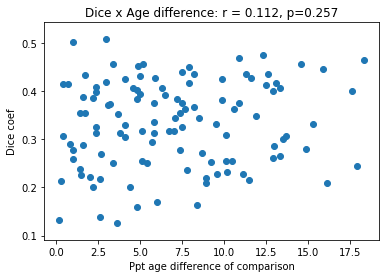

In [29]:
# If participants were more similar based on age then this should be negatively correlated
exclude_same_ppt = 1 # Do you want to exclude comparisons of the same participant across age (1) or use them (0)

age_list = np.asarray(df['Age'])[age_ordered_idx]
ppt_ids = np.asarray(df['ID'])[age_ordered_idx]
age_diffs = []
average_vals = []
for ppt_counter in range(len(age_list)):
    
    ppt_age = age_list[ppt_counter]
    
    # What are the idxs of the other sessions
    other_sessions = np.arange(len(age_list)) != ppt_counter
    
    # Get this participant's ID
    ppt_id = ppt_ids[ppt_counter][:-2]
    is_match = 0
    for other_session in np.where(other_sessions)[0]:
        # Check they are not the same participant
        if (ppt_ids[other_session][:-2] == ppt_id) and (exclude_same_ppt == 1):
            other_sessions[other_session] = False
            
    
    # Add these details if the participant isn't to be exclude
    age_diffs += list(abs(age_list[other_sessions] - ppt_age))
    average_vals += list(average_mat[ppt_counter, other_sessions])


# Plot the relationship
unique_vals, unique_idxs = np.unique(np.asarray(age_diffs) * np.asarray(average_vals), return_index=True)

# Pull out all the non-bivariate duplicates and non-nans
age_diffs_nonnan = np.asarray(age_diffs)[unique_idxs][np.isnan(unique_vals) == 0]
average_vals_nonnan = np.asarray(average_vals)[unique_idxs][np.isnan(unique_vals) == 0]

# Get the correlation
corr_val = np.corrcoef(age_diffs_nonnan, average_vals_nonnan)[0, 1]

plt.scatter(age_diffs_nonnan, average_vals_nonnan)
plt.ylabel('Dice coef')
plt.xlabel('Ppt age difference of comparison')
plt.title('Dice x Age difference: r = %0.3f, p=%0.3f' % (corr_val, randomise_corr(age_diffs_nonnan, average_vals_nonnan)))

**Is Dice higher if the participants being compared are older participants?**  
If so, there will be a positive correlation between age and DICE

Text(0.5, 1.0, 'Dice x Age combo: r = 0.355, p=0.000')

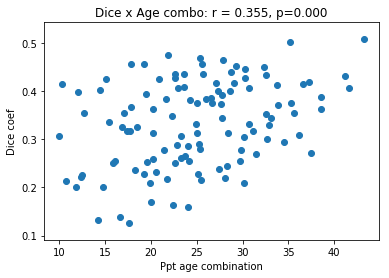

In [30]:

age_comb_add = 1 # Do you want to add (1) or multiply (0) the ages, or just take the first age (-1)
exclude_same_ppt = 1 # Do you want to exclude comparisons of the same participant across age (1) or use them (0)

ppt_ids = np.asarray(df['ID'])[age_ordered_idx]
age_comb = [] # Combine the two ages
age_diff = []
dice_vals = []
for ppt_1_counter, ppt_1_age in enumerate(age_list):
    for ppt_2_counter, ppt_2_age in enumerate(age_list):
        
        if (ppt_2_counter < ppt_1_counter) and (np.isnan(average_mat[ppt_1_counter, ppt_2_counter]) == 0):
            
            # Check ppt IDs
            ppt_1 = ppt_ids[ppt_1_counter][:-2]
            ppt_2 = ppt_ids[ppt_2_counter][:-2]
            
            # If these are different participants (or you don't want to exclude matches then do this)
            if (ppt_1 != ppt_2) or (exclude_same_ppt == 0):

                # Store the dice vals
                dice_vals += [average_mat[ppt_1_counter, ppt_2_counter]]

                # Store the age
                if age_comb_add == 1:
                    age_comb += [ppt_1_age + ppt_2_age]
                elif age_comb_add == 0:
                    age_comb += [ppt_1_age * ppt_2_age]
                elif age_comb_add == -1:
                    age_comb += [ppt_1_age]

                age_diff += [abs(ppt_1_age - ppt_2_age)]
            
# Get the correlation
corr_val = np.corrcoef(age_comb, dice_vals)[0, 1]

plt.scatter(age_comb, dice_vals)
plt.ylabel('Dice coef')
plt.xlabel('Ppt age combination')
plt.title('Dice x Age combo: r = %0.3f, p=%0.3f' % (corr_val, randomise_corr(age_comb, dice_vals)))

**Compute the alignment to standard mutual information**  
Quantify how well the data was mapped into standard by using the mutual information for each node, recorded in the `std.141.iBEAT_??.MI.1D` file

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


r=-0.060, p=0.819


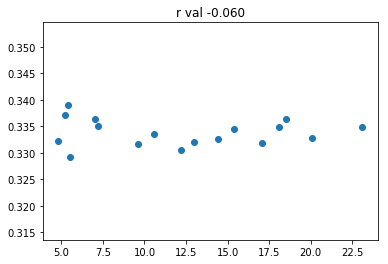

In [31]:
exclude_non_visual_nodes = 1 # Do you want to use only nodes from this participant that were labelled as part of an ROI (1) or use all (0)

MI_std_all = {}
for hemi in ['lh', 'rh']:
    MI_std_all[hemi] = []
    for ppt in df['ID']:
        
        input_file = '%s/iBEAT/%s/SUMA/std.141.iBEAT_%s.MI.1D' % (data_dir, ppt, hemi)
        trimmed_file = '%s/iBEAT/%s/SUMA/std.141.iBEAT_%s_trimmed.MI.1D' % (data_dir, ppt, hemi)
        
        # Make the trimmed file if it doesn't exist
        if os.path.exists(trimmed_file) == 0:
            os.system('tail -n +7 %s > %s' % (input_file, trimmed_file))
            print('Creating %s' % trimmed_file)
            
        MI_mat = np.loadtxt(trimmed_file)
        
        # Do you want to exclude nodes not in visual cortex
        if exclude_non_visual_nodes == 1:
            
            # Load the file
            manual_ROI_file = '%s/iBEAT/%s/SUMA/std.141.%s.manual.1D' % (data_dir, ppt, hemi)
            if os.path.exists(manual_ROI_file):
                manual_ROI = np.loadtxt(manual_ROI_file)

                # What idxs are usable (have a non zero in one of the columns)
                usable_idxs = np.where(np.sum(manual_ROI, 1) > 0)[0]
            else:
                usable_idxs = []
                
        else:
            usable_idxs = np.arange(MI_mat.shape[0])
            
            
        MI_std_all[hemi] += [np.mean(MI_mat[usable_idxs, 4])]

averaged_MI_std_all = np.nanmean((np.asarray(MI_std_all['lh']), np.asarray(MI_std_all['rh'])), 0)
r_val = np.corrcoef(averaged_MI_std_all, df['Age'])[0, 1]    
p_val = randomise_corr(averaged_MI_std_all, df['Age'])
print('r=%0.3f, p=%0.3f' % (r_val, p_val))
plt.title('r val %0.3f' % r_val)
plt.scatter(df['Age'], averaged_MI_std_all)


## Compute line oscilliations

Take in the lines drawn for each participant. Must use the original ROI files since they are ordered posterior to anterior. File has the name `std.141.??h.lines.niml.roi` where the first letter is either d or v and the second is either l or r. This file cannot be converted into a 1D file because otherwise it will collapse all of the labels with the same name.

Below we first run this analysis using lines that are perpendicular to the region boundaries (i.e., they traverse the visual cortex), and then second run it on lines that are parallel to the region boundaries (i.e., they emanate out from the fovea)

In [32]:
# What parameters do you want to set up
run_nonparametric = 2 # Means it uses the parametric distribution as the CI bands
max_len = 200 # How many elements do you want to use for interpolation

# Reset
np.random.seed(0)    

**Spatial frequency activity for lines perpendicular to the region boundary**  
Averages across both the left and right hemisphere within ventral or dorsal.

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:559: RuntimeWarning: Mean of empty slice


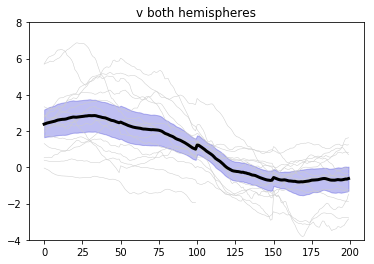

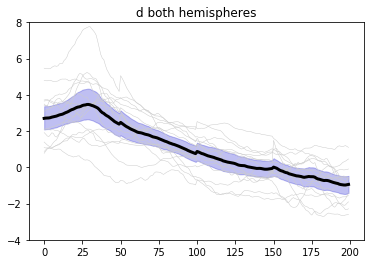

In [33]:
# Plot the oscillation information
output_name, _ = plot_line_oscillations(plot_cond='sf', prefix='v', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, run_nonparametric=run_nonparametric)

plt.ylim([-4, 8])
plt.savefig(output_name)

output_name, _ = plot_line_oscillations(plot_cond='sf', prefix='d', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, run_nonparametric=run_nonparametric)

plt.ylim([-4, 8])
plt.savefig(output_name)


**Meridian mapping activity for lines perpendicular to the region boundary**  
Averages across both the left and right hemisphere within ventral or dorsal.

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:559: RuntimeWarning: Mean of empty slice


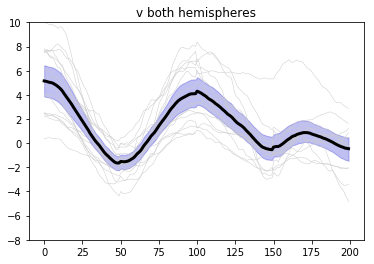

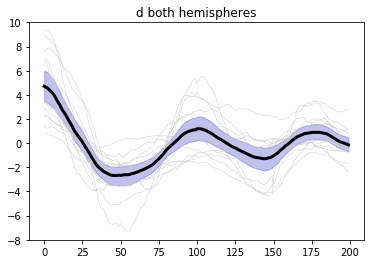

In [34]:
output_name, _ = plot_line_oscillations(plot_cond='meridian', prefix='v', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, run_nonparametric=run_nonparametric)

plt.ylim([-8, 10])
plt.savefig(output_name)

output_name, _ = plot_line_oscillations(plot_cond='meridian', prefix='d', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, run_nonparametric=run_nonparametric)

plt.ylim([-8, 10])
plt.savefig(output_name)


**Spatial frequency activity for lines parallel/orthogonal to the region boundary**  
Averages across both the left and right hemisphere within ventral or dorsal.

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:559: RuntimeWarning: Mean of empty slice


Compute the first quartile vs last quartile for each region
V1
Start=4.72, end=0.90, CI=[3.18, 4.55], p=0.000
Correlation with age r=0.00, p=0.958
V2
Start=3.47, end=0.16, CI=[2.53, 4.22], p=0.000
Correlation with age r=0.04, p=0.793
V3
Start=1.22, end=-0.38, CI=[0.96, 2.25], p=0.000
Correlation with age r=0.52, p=0.014
dV3AB
Start=-0.63, end=-0.47, CI=[-0.96, 0.61], p=0.695
Correlation with age r=0.18, p=0.520
vV4
Start=-0.79, end=-0.23, CI=[-1.23, 0.05], p=0.081
Correlation with age r=0.26, p=0.258
Test whether there is an average difference across regions
V1 > V2
Region 1=2.86, Region 2=1.72, CI=[0.82, 1.50], p=0.000
V2 > V3
Region 1=1.72, Region 2=0.22, CI=[1.21, 2.11], p=0.000
vV3 > vV4
Region 1=0.21, Region 2=-0.70, CI=[0.38, 1.51], p=0.001
dV3 > dV3AB
Region 1=0.22, Region 2=-0.66, CI=[0.52, 1.26], p=0.000
Correlate the mean of each region with age
Correlation of age and mean V1: 0.35, p=0.162
Correlation of age and mean V2: 0.27, p=0.300
Correlation of age and mean V3: -0.12, p

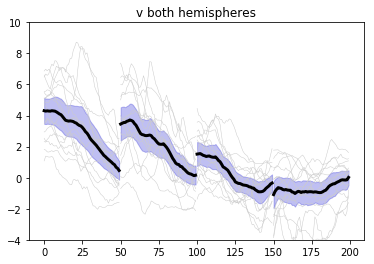

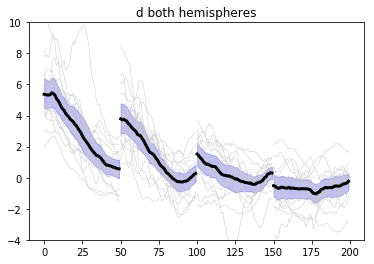

In [35]:
output_name, ventral_vals = plot_line_oscillations(plot_cond='sf', prefix='v', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, use_ortho=True, run_nonparametric=run_nonparametric)

plt.ylim([-4, 10])
plt.savefig(output_name)

output_name, dorsal_vals = plot_line_oscillations(plot_cond='sf', prefix='d', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, use_ortho=True, run_nonparametric=run_nonparametric)

plt.ylim([-4, 10])
plt.savefig(output_name)


# Average the ventral and dorsal
data_vals = (ventral_vals + dorsal_vals) / 2

window = 12 # How big is the window you want to use

print('Compute the first quartile vs last quartile for each region')
for region_counter in range(3):
    
    print('%s' % rois[region_counter][1:])
    split_quartile(data_vals, region_counter)

print('dV3AB')
split_quartile(dorsal_vals, 3)        
print('vV4')
split_quartile(ventral_vals, 3)    


print('Test whether there is an average difference across regions')
for region_counter in range(2):
    start_1 = int(region_counter * max_len / 4)
    end_1 = int((region_counter + 1) * max_len / 4)
    end_2 = int((region_counter + 2) * max_len / 4)
    region_1 = np.mean(data_vals[:, start_1:end_1], 1)
    region_2 = np.mean(data_vals[:, end_1:end_2], 1)
    diff_region = region_1 - region_2
    diff_region = diff_region[np.isnan(diff_region) == 0]
    pval, _, CI = randomise_diff(diff_region)
    
    print('%s > %s' % (rois[region_counter][1:], rois[region_counter + 1][1:]))
    print('Region 1=%0.2f, Region 2=%0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (np.nanmean(region_1), np.nanmean(region_2), CI[0], CI[1], pval))
    
    
for region_counter in range(2, 3):
    start_1 = int(region_counter * max_len / 4)
    end_1 = int((region_counter + 1) * max_len / 4)
    end_2 = int((region_counter + 2) * max_len / 4)
    region_1 = np.mean(ventral_vals[:, start_1:end_1], 1)
    region_2 = np.mean(ventral_vals[:, end_1:end_2], 1)
    diff_region = region_1 - region_2
    diff_region = diff_region[np.isnan(diff_region) == 0]
    pval, _, CI = randomise_diff(diff_region)
    
    print('%s > %s' % (rois[region_counter], rois[region_counter + 1]))
    print('Region 1=%0.2f, Region 2=%0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (np.nanmean(region_1), np.nanmean(region_2), CI[0], CI[1], pval))
        
for region_counter in range(2, 3):
    start_1 = int(region_counter * max_len / 4)
    end_1 = int((region_counter + 1) * max_len / 4)
    end_2 = int((region_counter + 2) * max_len / 4)
    region_1 = np.mean(dorsal_vals[:, start_1:end_1], 1)
    region_2 = np.mean(dorsal_vals[:, end_1:end_2], 1)
    diff_region = region_1 - region_2
    diff_region = diff_region[np.isnan(diff_region) == 0]
    pval, _, CI = randomise_diff(diff_region)
    
    print('%s > %s' % (rois[region_counter + 4], rois[region_counter + 5]))
    print('Region 1=%0.2f, Region 2=%0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (np.nanmean(region_1), np.nanmean(region_2), CI[0], CI[1], pval))
         
# Compute the relationship between spatial frequency contrast and age        
mean_or_slope = 0 # Do you want the mean of a region (0) or the slope (1)

print('Correlate the mean of each region with age')
for region_counter in range(5):
    
    # Pull out the values for this section
    if region_counter == 3:
        
        region_vals = ventral_vals[:, 150:]
        region = 'vV4'
    elif region_counter == 4:
        
        region_vals = dorsal_vals[:, 150:]
        region = 'V3A/B'
    else:
        region_vals = data_vals[:, region_counter * 50:(region_counter + 1) * 50]
        region = rois[region_counter][1:]
        
    # only take the non-nans now
    usable_ppts = np.isnan(region_vals[:,0]) == 0
    
    if mean_or_slope == 0:
        aggregate_vals = np.mean(region_vals[usable_ppts, :], 1)
        metric_name = 'mean'
    else:
        
        # Compute the slope
        aggregate_vals = []
        for ppt_counter in np.where(usable_ppts)[0]:
            aggregate_vals += [np.polyfit(np.arange(region_vals.shape[1]), region_vals[ppt_counter, :], 1)[0]]
        
        aggregate_vals = np.asarray(aggregate_vals)
    
    pval_corr = randomise_corr(aggregate_vals, np.asarray(df['Age'][usable_ppts]))
    
    print('Correlation of age and %s %s: %0.2f, p=%0.3f' % (metric_name, region, np.corrcoef(aggregate_vals, df['Age'][usable_ppts])[0, 1], pval_corr))
    
    


**Meridian mapping activity for lines parallel/orthogonal to the region boundary**  
Averages across both the left and right hemisphere within ventral or dorsal.

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:559: RuntimeWarning: Mean of empty slice


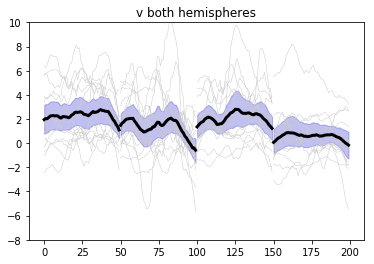

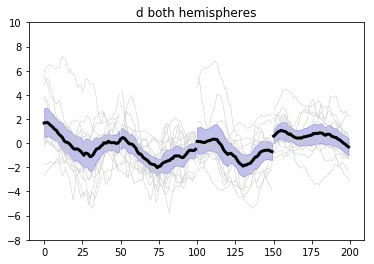

In [36]:
output_name, _ = plot_line_oscillations(plot_cond='meridian', prefix='v', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, use_ortho=True, run_nonparametric=run_nonparametric)

plt.ylim([-8, 10])
plt.savefig(output_name)

output_name, _ = plot_line_oscillations(plot_cond='meridian', prefix='d', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, use_ortho=True, run_nonparametric=run_nonparametric)

plt.ylim([-8, 10])
plt.savefig(output_name)



**Make the above plots on only the participants under 6 months of age**

In [37]:
# What participants would you like to use
ppt_idxs = np.where(np.asarray(df['Age'])<6)[0]
suffix_name = '_under_6'

Using: ['s4047_1_1' 's8047_1_1' 's2097_1_1' 's2077_1_1']


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:559: RuntimeWarning: Mean of empty slice
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Using: ['s4047_1_1' 's8047_1_1' 's2097_1_1' 's2077_1_1']
Using: ['s4047_1_1' 's8047_1_1' 's2097_1_1' 's2077_1_1']
Using: ['s4047_1_1' 's8047_1_1' 's2097_1_1' 's2077_1_1']


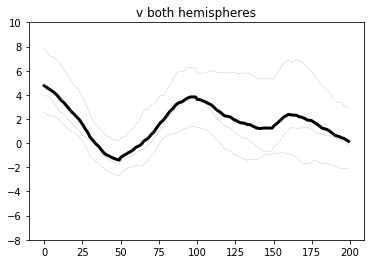

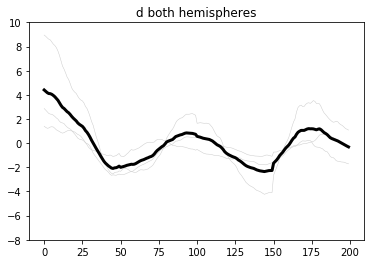

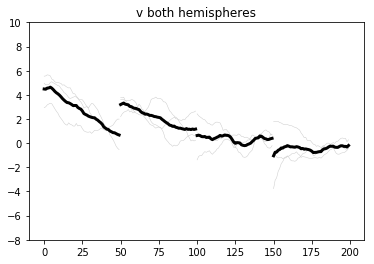

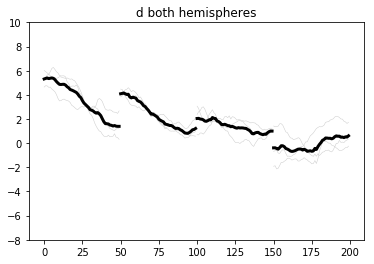

In [38]:
# Meridian
output_name, _ = plot_line_oscillations(plot_cond='meridian', prefix='v', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, run_nonparametric=run_nonparametric, ppt_idxs=ppt_idxs)

plt.ylim([-8, 10])
plt.savefig(output_name[:-4] + suffix_name + '.svg')

output_name, _ = plot_line_oscillations(plot_cond='meridian', prefix='d', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, run_nonparametric=run_nonparametric, ppt_idxs=ppt_idxs)

plt.ylim([-8, 10])
plt.savefig(output_name[:-4] + suffix_name + '.svg')

# SF
output_name, _ = plot_line_oscillations(plot_cond='sf', prefix='v', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, use_ortho=True, run_nonparametric=run_nonparametric, ppt_idxs=ppt_idxs)

plt.ylim([-8, 10])
plt.savefig(output_name[:-4] + suffix_name + '.svg')


output_name, _ = plot_line_oscillations(plot_cond='sf', prefix='d', max_len=max_len, interpolate_data=True, interpolate_within_roi=True, aggregate_lines=0, use_ortho=True, run_nonparametric=run_nonparametric, ppt_idxs=ppt_idxs)
plt.ylim([-8, 10])
plt.savefig(output_name[:-4] + suffix_name + '.svg')


